In [1]:
import codecs
from os import path
import pandas as pd
import pdb
import logging
import re
from gensim import parsing
import gensim
from gensim.parsing.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report

In [2]:
from baal.active import get_heuristic
from baal.active.active_loop import ActiveLearningLoop
from baal.active.dataset.nlp_datasets import active_huggingface_dataset, HuggingFaceDatasets
from baal.bayesian.dropout import patch_module
from baal.transformers_trainer_wrapper import BaalTransformersTrainer
from copy import deepcopy

In [3]:
from sklearn.metrics import accuracy_score

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny") 

In [5]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="transformer_checkpoints",  # specify the directory where models weights will be saved a certain points during training (checkpoints)
    num_train_epochs=1,  # change this if it is taking too long on your computer
)  

In [6]:
def calculate(a):
    rotated = list(zip(*a[::-1]))
    median0 = []
    min0 = []
    max0 = []
    for i in range(len(rotated)):
        median0.append(np.median(rotated[i]))
        min0.append(np.min(rotated[i]))
        max0.append(np.max(rotated[i]))
    return median0,min0,max0

# Abortion

In [7]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_abortion)} instances loaded")

val_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_abortion)} instances loaded")

test_dataset_abortion = load_dataset(
    "tweet_eval",
    name="stance_abortion",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_abortion)} instances loaded")

num_classes = np.unique(train_dataset_abortion['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 587 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 66 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_abortion\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 280 instances loaded


In [8]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [9]:
active_mc_abortion1= []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
#     n_labeled_examples = np.unique(train_dataset_abortion['text']).size
#     training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
#     print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label([0,1,2,3,4,8,9,15,20])
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
    print(performance_history_abortion)
    active_mc_abortion1.append(performance_history_abortion)
    mcrun = mcrun + 1

***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:14:55.198550Z [info     ] Start Predict                  dataset=578


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.49it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:14:59.575549Z [info     ] Start Predict                  dataset=558


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 31.38it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:15:04.306715Z [info     ] Start Predict                  dataset=538


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.70it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:15:08.938717Z [info     ] Start Predict                  dataset=518


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.40it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:15:14.492784Z [info     ] Start Predict                  dataset=498


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:15:20.027359Z [info     ] Start Predict                  dataset=478


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.59it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:15:27.303556Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.82it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:15:33.985650Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.19it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:15:41.403831Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 32.74it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:15:49.202327Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.33it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:15:56.430327Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.47it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:16:02.723325Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.41it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:16:11.747609Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.81it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:16:19.985752Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.61it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:16:29.537953Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.66it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:16:37.187495Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.72it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:16:44.283495Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.95it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:16:52.928827Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.21it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:17:01.007862Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.65it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:17:10.411064Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:17:18.573063Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.48it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:17:26.905065Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.90it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:17:34.868066Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.35it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:17:43.107065Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.09it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:17:51.563063Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 36.11it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:18:00.152613Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.11it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:18:09.115128Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 32.52it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:18:18.078129Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 33.11it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:18:27.479128Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.10it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.42142857142857143, 0.3964285714285714, 0.3892857142857143, 0.44642857142857145, 0.5321428571428571, 0.5428571428571428, 0.5214285714285715, 0.6321428571428571, 0.6178571428571429, 0.6392857142857142, 0.6071428571428571, 0.6607142857142857, 0.6535714285714286, 0.6464285714285715, 0.6678571428571428, 0.6678571428571428, 0.6678571428571428, 0.6642857142857143, 0.6678571428571428, 0.6714285714285714, 0.6678571428571428, 0.675, 0.6607142857142857, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.6714285714285714]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:18:40.762398Z [info     ] Start Predict                  dataset=578


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 31.60it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:18:45.384864Z [info     ] Start Predict                  dataset=558


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 32.04it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:18:49.870862Z [info     ] Start Predict                  dataset=538


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 31.14it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:18:54.922865Z [info     ] Start Predict                  dataset=518


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 29.43it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:19:00.308850Z [info     ] Start Predict                  dataset=498


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:02<00:00, 23.32it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:19:06.421736Z [info     ] Start Predict                  dataset=478


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 32.79it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:19:11.999735Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 31.71it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:19:18.836788Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 30.22it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:19:25.533760Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 30.42it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:19:32.138820Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.18it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:19:38.375929Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.97it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:19:44.365931Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.14it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:19:50.730928Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 32.48it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:19:57.530479Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 34.19it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:20:04.448480Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.51it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:20:12.192479Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 34.35it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:20:20.309557Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.77it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:20:29.241976Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.38it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:20:37.594070Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.48it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:20:46.855500Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:20:55.544806Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.06it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:21:04.030272Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.15it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:21:12.005306Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 36.14it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:21:19.871821Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.01it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:21:27.909797Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 35.81it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:21:36.231795Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 35.06it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:21:44.965059Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 28.07it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:21:54.225653Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 35.72it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:22:03.543743Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 42.86it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.42142857142857143, 0.3964285714285714, 0.3892857142857143, 0.44642857142857145, 0.5321428571428571, 0.5428571428571428, 0.5214285714285715, 0.6321428571428571, 0.6178571428571429, 0.6392857142857142, 0.6071428571428571, 0.6607142857142857, 0.6535714285714286, 0.6464285714285715, 0.6678571428571428, 0.6678571428571428, 0.6678571428571428, 0.6642857142857143, 0.6678571428571428, 0.6714285714285714, 0.6678571428571428, 0.675, 0.6607142857142857, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.6714285714285714]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:22:17.465775Z [info     ] Start Predict                  dataset=578


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 34.18it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:22:21.872773Z [info     ] Start Predict                  dataset=558


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 34.06it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:22:26.267774Z [info     ] Start Predict                  dataset=538


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:01<00:00, 34.30it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:22:30.792292Z [info     ] Start Predict                  dataset=518


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.40it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:22:35.499810Z [info     ] Start Predict                  dataset=498


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.89it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:22:40.401933Z [info     ] Start Predict                  dataset=478


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.54it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:22:45.651929Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 34.48it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:22:50.798930Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.46it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:22:56.787499Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.42it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:23:02.424063Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.22it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:23:08.237581Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.80it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:23:14.197682Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 35.27it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:23:20.285683Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 35.54it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:23:26.422683Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 35.03it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:23:32.848684Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 35.45it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:23:39.379609Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:00<00:00, 35.35it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:23:46.039881Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 35.69it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:23:52.908397Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.34it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:24:00.239424Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 35.40it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:24:07.569535Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 34.84it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:24:14.999526Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.38it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:24:23.110528Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 35.40it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:24:31.748338Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 36.00it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:24:39.684338Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 35.21it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:24:47.674891Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 36.31it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:24:56.635893Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 32.68it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:25:05.903892Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.70it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:25:14.928892Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.97it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:25:24.086892Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 32.61it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.42142857142857143, 0.3964285714285714, 0.3892857142857143, 0.44642857142857145, 0.5321428571428571, 0.5428571428571428, 0.5214285714285715, 0.6321428571428571, 0.6178571428571429, 0.6392857142857142, 0.6071428571428571, 0.6607142857142857, 0.6535714285714286, 0.6464285714285715, 0.6678571428571428, 0.6678571428571428, 0.6678571428571428, 0.6642857142857143, 0.6678571428571428, 0.6714285714285714, 0.6678571428571428, 0.675, 0.6607142857142857, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.6714285714285714]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:25:37.366890Z [info     ] Start Predict                  dataset=578


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.97it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:25:41.617892Z [info     ] Start Predict                  dataset=558


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 33.64it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:25:46.736499Z [info     ] Start Predict                  dataset=538


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.83it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:25:53.167277Z [info     ] Start Predict                  dataset=518


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.87it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:25:58.242274Z [info     ] Start Predict                  dataset=498


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 34.18it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:26:04.582488Z [info     ] Start Predict                  dataset=478


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 34.03it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:26:11.646602Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 34.46it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:26:17.796458Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.95it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:26:24.945393Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 32.30it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:26:32.406428Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 30.60it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:26:40.928201Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 32.99it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:26:47.198199Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 32.47it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:26:53.528200Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 31.76it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:27:00.425200Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.67it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:27:07.326200Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.79it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:27:14.403202Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 32.62it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:27:21.608715Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:01<00:00, 32.04it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:27:28.954718Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.48it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:27:36.768238Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.27it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:27:44.335238Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 31.45it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:27:52.162241Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.39it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:28:00.290238Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:28:08.400276Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 30.25it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:28:16.832300Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 32.97it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:28:25.807892Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 35.42it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:28:34.684434Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.90it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:28:44.015763Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 33.47it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:28:53.816507Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.19it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:29:03.197969Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.54it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.42142857142857143, 0.3964285714285714, 0.3892857142857143, 0.44642857142857145, 0.5321428571428571, 0.5428571428571428, 0.5214285714285715, 0.6321428571428571, 0.6178571428571429, 0.6392857142857142, 0.6071428571428571, 0.6607142857142857, 0.6535714285714286, 0.6464285714285715, 0.6678571428571428, 0.6678571428571428, 0.6678571428571428, 0.6642857142857143, 0.6678571428571428, 0.6714285714285714, 0.6678571428571428, 0.675, 0.6607142857142857, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.6714285714285714]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:29:16.265008Z [info     ] Start Predict                  dataset=578


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 32.50it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:29:20.604006Z [info     ] Start Predict                  dataset=558


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 32.88it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:29:25.312067Z [info     ] Start Predict                  dataset=538


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.12it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:29:29.953064Z [info     ] Start Predict                  dataset=518


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.01it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:29:34.908066Z [info     ] Start Predict                  dataset=498


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.86it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:29:39.989067Z [info     ] Start Predict                  dataset=478


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 32.07it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:29:45.324068Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.03it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:29:50.765065Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.08it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:29:56.485618Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.00it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:30:02.381642Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.92it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:30:08.444646Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.17it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:30:14.691660Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:30:20.897642Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.36it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:30:27.518643Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.36it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:30:34.250643Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.60it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:30:41.191190Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.43it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:30:48.358187Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.09it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:30:55.546185Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.12it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:31:03.048184Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 33.86it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:31:10.627189Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.24it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:31:18.429185Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.69it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:31:26.387183Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.11it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:31:34.867272Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.90it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:31:43.164786Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 33.63it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:31:51.624788Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.03it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:32:00.312787Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.78it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:32:10.159785Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.87it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:32:19.054788Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.01it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:32:28.265297Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 39.47it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.42142857142857143, 0.3964285714285714, 0.3892857142857143, 0.44642857142857145, 0.5321428571428571, 0.5428571428571428, 0.5214285714285715, 0.6321428571428571, 0.6178571428571429, 0.6392857142857142, 0.6071428571428571, 0.6607142857142857, 0.6535714285714286, 0.6464285714285715, 0.6678571428571428, 0.6678571428571428, 0.6678571428571428, 0.6642857142857143, 0.6678571428571428, 0.6714285714285714, 0.6678571428571428, 0.675, 0.6607142857142857, 0.675, 0.675, 0.675, 0.675, 0.6714285714285714, 0.675, 0.6714285714285714]


In [10]:
active_mc_abortion2= []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
#     n_labeled_examples = np.unique(train_dataset_abortion['text']).size
#     training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
#     print(training_indices0)
    active_set_abortion =active_huggingface_dataset(train_dataset_abortion,tokenizer,'label','text')
    valid_set_abortion = HuggingFaceDatasets(test_dataset_abortion,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_abortion.can_label = False
    active_set_abortion.label_randomly(9)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_abortion,
            eval_dataset=valid_set_abortion,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_abortion = ActiveLearningLoop(active_set_abortion,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_abortion=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_abortion.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_abortion.labelled_map,
            "Next Training set size": len(active_set_abortion),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_abortion.append(eval_metrics['eval_accuracy'])
    print(performance_history_abortion)
    active_mc_abortion2.append(performance_history_abortion)
    mcrun = mcrun + 1

D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:32:41.102296Z [info     ] Start Predict                  dataset=578


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.38it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:32:45.326296Z [info     ] Start Predict                  dataset=558


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 32.82it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:32:49.802821Z [info     ] Start Predict                  dataset=538


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.28it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:32:54.374821Z [info     ] Start Predict                  dataset=518


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.11it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:32:59.422823Z [info     ] Start Predict                  dataset=498


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.44it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:33:04.422374Z [info     ] Start Predict                  dataset=478


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 32.17it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:33:09.705890Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 35.09it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:33:15.110920Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 34.81it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:33:20.551409Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 34.94it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:33:26.912411Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.77it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:33:33.743409Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 35.24it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:33:39.732409Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 34.46it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:33:45.946449Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 34.93it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:33:52.380962Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.31it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:33:59.127961Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 35.06it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:34:05.671964Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.98it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:34:12.425483Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 35.26it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:34:19.337486Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.44it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:34:26.564483Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.10it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:34:35.835741Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.60it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:34:44.453761Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.29it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:34:52.382400Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.73it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:35:00.504445Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.22it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:35:08.738467Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.80it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:35:17.146436Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.95it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:35:25.735436Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.48it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:35:34.566974Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.70it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:35:43.499103Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.12it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:35:52.653633Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 42.25it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.36428571428571427, 0.3892857142857143, 0.37142857142857144, 0.4107142857142857, 0.37857142857142856, 0.36428571428571427, 0.3892857142857143, 0.4, 0.5357142857142857, 0.475, 0.5464285714285714, 0.6178571428571429, 0.625, 0.6321428571428571, 0.625, 0.6321428571428571, 0.6678571428571428, 0.6571428571428571, 0.6535714285714286, 0.6821428571428572, 0.6321428571428571, 0.675, 0.6464285714285715, 0.675, 0.6785714285714286, 0.6714285714285714, 0.675, 0.6642857142857143, 0.675, 0.6714285714285714]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:36:05.266692Z [info     ] Start Predict                  dataset=578


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.46it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:36:09.572662Z [info     ] Start Predict                  dataset=558


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 33.32it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:36:14.110662Z [info     ] Start Predict                  dataset=538


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.55it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:36:18.563794Z [info     ] Start Predict                  dataset=518


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:36:25.360904Z [info     ] Start Predict                  dataset=498


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.49it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:36:30.359902Z [info     ] Start Predict                  dataset=478


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.39it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:36:35.650282Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.39it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:36:41.128296Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.43it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:36:47.666297Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.84it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:36:53.657295Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.51it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:36:59.676295Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.71it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:37:05.770296Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.78it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:37:12.050841Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.99it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:37:18.479870Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.14it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:37:25.145840Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.87it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:37:31.959871Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 32.74it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:37:39.162691Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.71it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:37:46.251548Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.63it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:37:54.538701Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.74it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:38:03.404425Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.38it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:38:11.116425Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.33it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:38:18.990426Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.73it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:38:26.975429Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.71it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:38:35.246455Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 33.04it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:38:43.627694Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.67it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:38:54.130451Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.01it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:39:04.045095Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.87it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:39:12.850092Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.01it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:39:22.051122Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 44.10it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.40714285714285714, 0.4035714285714286, 0.45, 0.4928571428571429, 0.5214285714285715, 0.5071428571428571, 0.575, 0.6178571428571429, 0.5964285714285714, 0.6428571428571429, 0.6285714285714286, 0.6642857142857143, 0.6285714285714286, 0.6428571428571429, 0.6607142857142857, 0.6535714285714286, 0.6678571428571428, 0.6607142857142857, 0.6678571428571428, 0.6785714285714286, 0.675, 0.675, 0.6535714285714286, 0.675, 0.6785714285714286, 0.675, 0.6714285714285714, 0.6714285714285714, 0.675, 0.6714285714285714]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:39:34.870602Z [info     ] Start Predict                  dataset=578


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.72it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:39:39.177604Z [info     ] Start Predict                  dataset=558


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 33.21it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:39:43.748601Z [info     ] Start Predict                  dataset=538


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.35it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:39:48.506632Z [info     ] Start Predict                  dataset=518


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 32.89it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:39:53.400603Z [info     ] Start Predict                  dataset=498


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.69it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:39:58.486603Z [info     ] Start Predict                  dataset=478


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:40:03.782118Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.37it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:40:09.128121Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.29it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:40:14.727119Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.93it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:40:20.540117Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.58it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:40:26.456119Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.64it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:40:32.638118Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.76it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:40:38.948120Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.62it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:40:45.672119Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.56it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:40:52.354119Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 32.99it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:40:59.136117Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.62it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:41:06.197117Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 34.06it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:41:13.318119Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.82it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:41:20.659148Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.53it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:41:28.205152Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.78it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:41:35.937150Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.09it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:41:45.240093Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.73it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:41:53.308570Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 34.62it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:42:02.640589Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 33.86it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:42:12.694701Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 34.30it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:42:22.292836Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.60it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:42:31.059838Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 36.04it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:42:40.091555Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.01it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:42:49.299357Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.69it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.40714285714285714, 0.4035714285714286, 0.45, 0.4928571428571429, 0.5214285714285715, 0.5071428571428571, 0.575, 0.6178571428571429, 0.5964285714285714, 0.6428571428571429, 0.6285714285714286, 0.6642857142857143, 0.6285714285714286, 0.6428571428571429, 0.6607142857142857, 0.6535714285714286, 0.6678571428571428, 0.6607142857142857, 0.6678571428571428, 0.6785714285714286, 0.675, 0.675, 0.6535714285714286, 0.675, 0.6785714285714286, 0.675, 0.6714285714285714, 0.6714285714285714, 0.675, 0.6714285714285714]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:43:03.203442Z [info     ] Start Predict                  dataset=578


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 32.29it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:43:07.736443Z [info     ] Start Predict                  dataset=558


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 31.76it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:43:12.306444Z [info     ] Start Predict                  dataset=538


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 31.91it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:43:17.114445Z [info     ] Start Predict                  dataset=518


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:02<00:00, 30.04it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:43:22.818952Z [info     ] Start Predict                  dataset=498


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 32.08it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:43:28.177952Z [info     ] Start Predict                  dataset=478


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 31.78it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:43:34.687952Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.43it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:43:40.216036Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 33.13it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:43:45.909034Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 32.96it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:43:51.828038Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.40it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:43:58.209566Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.31it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:44:05.434617Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 33.16it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:44:11.881017Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.54it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:44:18.543047Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.53it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:44:25.275018Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.57it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:44:32.474017Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.05it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:44:39.663018Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.92it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:44:46.857021Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.41it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:44:54.278016Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 32.98it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:45:01.949529Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.74it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:45:10.499530Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.87it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:45:18.446224Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 34.90it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:45:27.365194Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 35.43it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:45:35.511196Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 34.80it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:45:43.893195Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 35.52it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:45:52.439195Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.47it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:46:01.129196Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.38it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:46:09.846707Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.72it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:46:18.995706Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.91it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.40714285714285714, 0.4035714285714286, 0.45, 0.4928571428571429, 0.5214285714285715, 0.5071428571428571, 0.575, 0.6178571428571429, 0.5964285714285714, 0.6428571428571429, 0.6285714285714286, 0.6642857142857143, 0.6285714285714286, 0.6428571428571429, 0.6607142857142857, 0.6535714285714286, 0.6678571428571428, 0.6607142857142857, 0.6678571428571428, 0.6785714285714286, 0.675, 0.675, 0.6535714285714286, 0.675, 0.6785714285714286, 0.675, 0.6714285714285714, 0.6714285714285714, 0.675, 0.6714285714285714]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:46:31.691258Z [info     ] Start Predict                  dataset=578


100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:02<00:00, 33.11it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:46:36.195213Z [info     ] Start Predict                  dataset=558


100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [00:02<00:00, 32.71it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:46:41.622736Z [info     ] Start Predict                  dataset=538


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:02<00:00, 33.50it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:46:46.197738Z [info     ] Start Predict                  dataset=518


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 32.91it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:46:52.700783Z [info     ] Start Predict                  dataset=498


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:01<00:00, 33.67it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:46:57.821757Z [info     ] Start Predict                  dataset=478


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 32.56it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:47:03.294163Z [info     ] Start Predict                  dataset=458


100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:01<00:00, 33.55it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:47:08.806163Z [info     ] Start Predict                  dataset=438


100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:01<00:00, 32.74it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:47:14.581162Z [info     ] Start Predict                  dataset=418


100%|██████████████████████████████████████████████████████████████████████████████████| 53/53 [00:01<00:00, 33.33it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:47:20.247162Z [info     ] Start Predict                  dataset=398


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.05it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:47:26.191161Z [info     ] Start Predict                  dataset=378


100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 33.23it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:47:32.339510Z [info     ] Start Predict                  dataset=358


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:01<00:00, 32.68it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:47:38.652481Z [info     ] Start Predict                  dataset=338


100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 33.97it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:47:45.212483Z [info     ] Start Predict                  dataset=318


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 33.22it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:47:51.987480Z [info     ] Start Predict                  dataset=298


100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 33.69it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:47:58.791480Z [info     ] Start Predict                  dataset=278


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.05it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:48:05.724626Z [info     ] Start Predict                  dataset=258


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 33.99it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:48:12.857626Z [info     ] Start Predict                  dataset=238


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.34it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:48:20.209543Z [info     ] Start Predict                  dataset=218


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 34.15it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:48:27.776058Z [info     ] Start Predict                  dataset=198


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:48:35.481060Z [info     ] Start Predict                  dataset=178


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.12it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:48:43.383061Z [info     ] Start Predict                  dataset=158


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.50it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:48:51.472057Z [info     ] Start Predict                  dataset=138


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 33.71it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:48:59.924058Z [info     ] Start Predict                  dataset=118


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 33.93it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:49:08.371149Z [info     ] Start Predict                  dataset=98


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 35.33it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:49:16.934353Z [info     ] Start Predict                  dataset=78


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.67it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:49:25.513354Z [info     ] Start Predict                  dataset=58


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 37.74it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:49:34.203416Z [info     ] Start Predict                  dataset=38


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 34.72it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:49:42.981071Z [info     ] Start Predict                  dataset=18


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.67it/s]
***** Running training *****
  Num examples = 587
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 280
  Batch size = 8


[0.40714285714285714, 0.4035714285714286, 0.45, 0.4928571428571429, 0.5214285714285715, 0.5071428571428571, 0.575, 0.6178571428571429, 0.5964285714285714, 0.6428571428571429, 0.6285714285714286, 0.6642857142857143, 0.6285714285714286, 0.6428571428571429, 0.6607142857142857, 0.6535714285714286, 0.6678571428571428, 0.6607142857142857, 0.6678571428571428, 0.6785714285714286, 0.675, 0.675, 0.6535714285714286, 0.675, 0.6785714285714286, 0.675, 0.6714285714285714, 0.6714285714285714, 0.675, 0.6714285714285714]


In [11]:
median_abortion1, min_abortion1,max_abortion1 = calculate(active_mc_abortion1)

In [12]:
median_abortion2, min_abortion2,max_abortion2 = calculate(active_mc_abortion2)

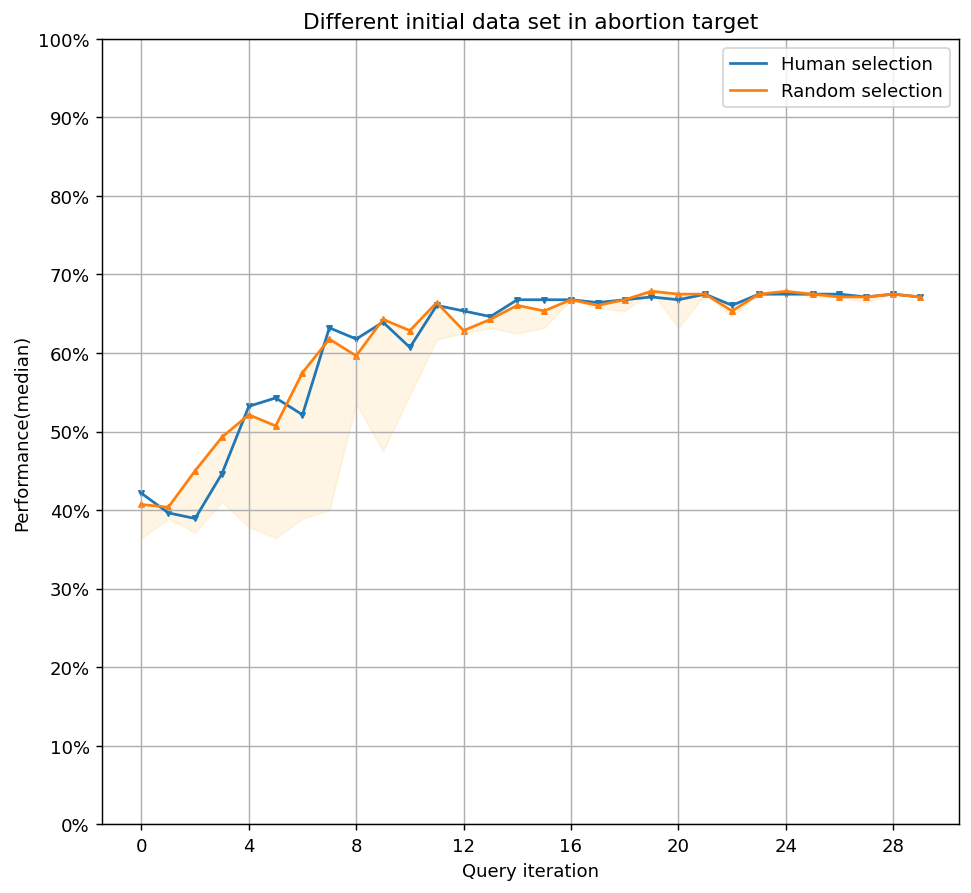

In [13]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(median_abortion1,label="Human selection")
ax.fill_between(range(30),min_abortion1,max_abortion1,color='blue', alpha=0.1)
ax.plot(median_abortion2,label="Random selection")
ax.fill_between(range(30),min_abortion2,max_abortion2,color='orange', alpha=0.1)

ax.scatter(range(30), median_abortion1, s=8,marker = "v")
ax.scatter(range(30), median_abortion2, s=8,marker="^")

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=8, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different initial data set in abortion target')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Performance(median)')

plt.show()

# Atheism

In [14]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_atheism = load_dataset(
    "tweet_eval",
    name="stance_atheism",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_atheism)} instances loaded")

val_dataset_atheism = load_dataset(
    "tweet_eval",
    name="stance_atheism",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_atheism)} instances loaded")

test_dataset_atheism = load_dataset(
    "tweet_eval",
    name="stance_atheism",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_atheism)} instances loaded")

num_classes = np.unique(train_dataset_atheism['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_atheism\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 461 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_atheism\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 52 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_atheism\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 220 instances loaded


In [15]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [16]:
active_mc_atheism1 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
#     n_labeled_examples = np.unique(train_dataset_atheism['text']).size
#     training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
#     print(training_indices0)
    active_set_atheism =active_huggingface_dataset(train_dataset_atheism,tokenizer,'label','text')
    valid_set_atheism = HuggingFaceDatasets(test_dataset_atheism,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_atheism.can_label = False
    active_set_atheism.label([0,1,2,3,4,9,11,12,22])
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_atheism,
            eval_dataset=valid_set_atheism,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_atheism = ActiveLearningLoop(active_set_atheism,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_atheism=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_atheism.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_atheism.labelled_map,
            "Next Training set size": len(active_set_atheism),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_atheism.append(eval_metrics['eval_accuracy'])
    print(performance_history_atheism)
    active_mc_atheism1.append(performance_history_atheism)
    mcrun = mcrun + 1

***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:00.115831Z [info     ] Start Predict                  dataset=452


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.18it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:03.662510Z [info     ] Start Predict                  dataset=432


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 33.09it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:07.474537Z [info     ] Start Predict                  dataset=412


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 33.35it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:11.315507Z [info     ] Start Predict                  dataset=392


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.60it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:15.543505Z [info     ] Start Predict                  dataset=372


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.19it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:19.717506Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.79it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:24.232506Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 34.15it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:28.763506Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.98it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:33.685232Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 34.32it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:38.530872Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 34.10it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:44.799937Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.15it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:50.546721Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 34.24it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:50:56.492722Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 34.39it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:51:02.188721Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.19it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:51:08.007429Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.95it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:51:14.072427Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.45it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:51:20.303430Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.41it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:51:27.095428Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.98it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:51:33.541429Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.78it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:51:40.172427Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.09it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:51:47.097944Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.71it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:51:54.179961Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:52:01.500986Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.22it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.4090909090909091, 0.42727272727272725, 0.4409090909090909, 0.4909090909090909, 0.5363636363636364, 0.6136363636363636, 0.65, 0.7, 0.6545454545454545, 0.7181818181818181, 0.7136363636363636, 0.7272727272727273, 0.7227272727272728, 0.7181818181818181, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:52:11.879016Z [info     ] Start Predict                  dataset=452


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.53it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:52:15.326988Z [info     ] Start Predict                  dataset=432


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 33.01it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:52:18.997988Z [info     ] Start Predict                  dataset=412


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.81it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:52:22.793988Z [info     ] Start Predict                  dataset=392


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.22it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:52:26.792530Z [info     ] Start Predict                  dataset=372


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.52it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:52:31.142527Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.71it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:52:35.678527Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.79it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:52:40.281525Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.45it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:52:48.612560Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.61it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:52:54.605561Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.32it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:52:59.683070Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.09it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:53:05.128070Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.69it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:53:10.618068Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 34.18it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:53:16.271074Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.15it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:53:22.161072Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 32.98it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:53:28.099102Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.37it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:53:34.375133Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.46it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:53:40.792103Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.27it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:53:47.431882Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.19it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:53:54.177147Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 30.93it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:54:01.030146Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 34.48it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:54:08.113174Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 32.79it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:54:15.434175Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 38.46it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.4090909090909091, 0.42727272727272725, 0.4409090909090909, 0.4909090909090909, 0.5363636363636364, 0.6136363636363636, 0.65, 0.7, 0.6545454545454545, 0.7181818181818181, 0.7136363636363636, 0.7272727272727273, 0.7227272727272728, 0.7181818181818181, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:54:25.748176Z [info     ] Start Predict                  dataset=452


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.30it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:54:29.118864Z [info     ] Start Predict                  dataset=432


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 33.01it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:54:32.826805Z [info     ] Start Predict                  dataset=412


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 33.35it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:54:36.614806Z [info     ] Start Predict                  dataset=392


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.24it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:54:40.799807Z [info     ] Start Predict                  dataset=372


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.79it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:54:45.068807Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.88it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:54:49.623734Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.47it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:54:54.334732Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.94it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:54:59.103732Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 32.69it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:55:04.109733Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.79it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:55:09.311735Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.44it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:55:14.672735Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.14it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:55:20.156763Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.34it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:55:25.875606Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.10it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:55:31.787603Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:55:37.716401Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.36it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:55:43.843916Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.27it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:55:50.106944Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.63it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:55:56.646282Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.29it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:56:03.432198Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.58it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:56:10.361200Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 30.57it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:56:17.439753Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:56:24.572873Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.19it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.4090909090909091, 0.42727272727272725, 0.4409090909090909, 0.4909090909090909, 0.5363636363636364, 0.6136363636363636, 0.65, 0.7, 0.6545454545454545, 0.7181818181818181, 0.7136363636363636, 0.7272727272727273, 0.7227272727272728, 0.7181818181818181, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:56:35.038303Z [info     ] Start Predict                  dataset=452


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 32.91it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:56:38.695893Z [info     ] Start Predict                  dataset=432


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.91it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:56:42.539895Z [info     ] Start Predict                  dataset=412


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 33.71it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:56:46.576408Z [info     ] Start Predict                  dataset=392


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.97it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:56:50.735438Z [info     ] Start Predict                  dataset=372


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.36it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:56:55.042408Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.76it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:56:59.873437Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.74it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:57:04.440410Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.28it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:57:09.444438Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 32.98it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:57:14.509446Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.50it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:57:19.755446Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.58it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:57:25.091445Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.45it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:57:30.601444Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.75it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:57:36.223475Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.56it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:57:42.141476Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.79it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:57:48.229474Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:57:54.415474Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.53it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:58:00.845993Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 30.91it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:58:07.481506Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 35.40it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:58:14.284542Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 32.85it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:58:21.224541Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.35it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:58:28.440001Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.75it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:58:35.804998Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 40.82it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.4090909090909091, 0.42727272727272725, 0.4409090909090909, 0.4909090909090909, 0.5363636363636364, 0.6136363636363636, 0.65, 0.7, 0.6545454545454545, 0.7181818181818181, 0.7136363636363636, 0.7272727272727273, 0.7227272727272728, 0.7181818181818181, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:58:46.067998Z [info     ] Start Predict                  dataset=452


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.11it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:58:49.554544Z [info     ] Start Predict                  dataset=432


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 33.15it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:58:53.278543Z [info     ] Start Predict                  dataset=412


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.68it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:58:57.243045Z [info     ] Start Predict                  dataset=392


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.91it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:59:01.491070Z [info     ] Start Predict                  dataset=372


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 32.81it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:59:05.694555Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.26it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:59:10.232225Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 32.53it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:59:14.787240Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.59it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:59:19.557009Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.12it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:59:24.629011Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.54it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:59:29.870040Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.99it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:59:35.292009Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.07it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:59:40.829009Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.62it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:59:46.482763Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.20it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:59:52.356760Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.38it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T11:59:58.465080Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.45it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:00:04.756597Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.14it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:00:11.103598Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.71it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:00:17.691431Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.29it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:00:24.430403Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 32.26it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:00:31.375405Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 33.65it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:00:38.474401Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.75it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:00:46.518431Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 42.56it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.4090909090909091, 0.42727272727272725, 0.4409090909090909, 0.4909090909090909, 0.5363636363636364, 0.6136363636363636, 0.65, 0.7, 0.6545454545454545, 0.7181818181818181, 0.7136363636363636, 0.7272727272727273, 0.7227272727272728, 0.7181818181818181, 0.7272727272727273, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


In [17]:
active_mc_atheism2 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
#     n_labeled_examples = np.unique(train_dataset_atheism['text']).size
#     training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
#     print(training_indices0)
    active_set_atheism =active_huggingface_dataset(train_dataset_atheism,tokenizer,'label','text')
    valid_set_atheism = HuggingFaceDatasets(test_dataset_atheism,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_atheism.can_label = False
    active_set_atheism.label_randomly(9)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_atheism,
            eval_dataset=valid_set_atheism,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_atheism = ActiveLearningLoop(active_set_atheism,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_atheism=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_atheism.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_atheism.labelled_map,
            "Next Training set size": len(active_set_atheism),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_atheism.append(eval_metrics['eval_accuracy'])
    print(performance_history_atheism)
    active_mc_atheism2.append(performance_history_atheism)
    mcrun = mcrun + 1

D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:00:57.064913Z [info     ] Start Predict                  dataset=452


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 32.33it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:00.620912Z [info     ] Start Predict                  dataset=432


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 31.99it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:04.495367Z [info     ] Start Predict                  dataset=412


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.30it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:08.295150Z [info     ] Start Predict                  dataset=392


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.33it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:12.797653Z [info     ] Start Predict                  dataset=372


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.80it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:17.104976Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.13it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:21.559976Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.12it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:26.306976Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.36it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:31.894039Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:37.025020Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.32it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:42.150022Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.92it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:47.409018Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.97it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:52.947022Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.54it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:01:58.689020Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.97it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:02:04.589147Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.74it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:02:10.529149Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.26it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:02:16.814148Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 32.67it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:02:23.205432Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 30.11it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:02:29.841432Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.58it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:02:36.600432Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.09it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:02:43.399502Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 34.48it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:02:50.552124Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 32.52it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:02:57.944124Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.04it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.5681818181818182, 0.5363636363636364, 0.6, 0.6, 0.6636363636363637, 0.6409090909090909, 0.6954545454545454, 0.7227272727272728, 0.7045454545454546, 0.7318181818181818, 0.7181818181818181, 0.7318181818181818, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:03:08.612677Z [info     ] Start Predict                  dataset=452


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.55it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:03:12.237675Z [info     ] Start Predict                  dataset=432


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 33.14it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:03:16.295896Z [info     ] Start Predict                  dataset=412


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.83it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:03:20.228902Z [info     ] Start Predict                  dataset=392


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.29it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:03:24.432896Z [info     ] Start Predict                  dataset=372


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.50it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:03:28.771427Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.72it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:03:33.312082Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 32.68it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:03:37.905051Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.75it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:03:42.844644Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 32.69it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:03:47.996645Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.01it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:03:53.155671Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.83it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:03:58.484741Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 30.49it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:04:04.186741Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 34.00it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:04:09.916741Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.92it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:04:15.774741Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.11it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:04:21.746253Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.87it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:04:27.839296Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.21it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:04:34.125266Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.02it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:04:40.715310Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.38it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:04:47.496306Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.83it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:04:55.204833Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 30.17it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:05:02.348316Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 32.00it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:05:09.559345Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 37.74it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.5636363636363636, 0.5454545454545454, 0.5818181818181818, 0.5818181818181818, 0.6636363636363637, 0.6727272727272727, 0.7090909090909091, 0.7272727272727273, 0.7181818181818181, 0.7227272727272728, 0.7181818181818181, 0.7227272727272728, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:05:19.872339Z [info     ] Start Predict                  dataset=452


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.39it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:05:23.383340Z [info     ] Start Predict                  dataset=432


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.71it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:05:27.118339Z [info     ] Start Predict                  dataset=412


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 33.58it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:05:31.105908Z [info     ] Start Predict                  dataset=392


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.36it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:05:35.743382Z [info     ] Start Predict                  dataset=372


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.17it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:05:39.907384Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.33it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:05:44.676396Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 29.04it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:05:49.663944Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.33it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:05:54.736014Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 30.88it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:06:00.085526Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.02it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:06:05.402683Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.06it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:06:10.753742Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.69it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:06:16.247413Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.57it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:06:22.004946Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.61it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:06:27.950947Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.54it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:06:34.037945Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 31.99it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:06:40.423946Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 32.57it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:06:46.884431Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.18it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:06:53.516431Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 32.88it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:07:00.319977Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 31.47it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:07:07.409950Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 36.08it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:07:14.608213Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.06it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:07:21.856213Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.22it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.5636363636363636, 0.5454545454545454, 0.5818181818181818, 0.5818181818181818, 0.6636363636363637, 0.6727272727272727, 0.7090909090909091, 0.7272727272727273, 0.7181818181818181, 0.7227272727272728, 0.7181818181818181, 0.7227272727272728, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:07:32.190583Z [info     ] Start Predict                  dataset=452


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 32.50it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:07:35.705582Z [info     ] Start Predict                  dataset=432


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 31.91it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:07:39.505586Z [info     ] Start Predict                  dataset=412


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 33.35it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:07:43.350609Z [info     ] Start Predict                  dataset=392


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.17it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:07:47.442611Z [info     ] Start Predict                  dataset=372


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 32.66it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:07:51.726130Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.81it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:07:56.264126Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.44it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:08:00.943126Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.33it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:08:05.800127Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.33it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:08:10.794127Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.85it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:08:16.138682Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.42it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:08:21.447165Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.81it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:08:27.038166Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.54it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:08:32.645165Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 31.37it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:08:38.593195Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 34.00it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:08:44.583163Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.37it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:08:50.879164Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.07it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:08:57.308166Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.71it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:09:03.931198Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 33.52it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:09:10.710679Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:09:17.744195Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.71it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:09:24.805194Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.61it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:09:32.159918Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 40.00it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.5636363636363636, 0.5454545454545454, 0.5818181818181818, 0.5818181818181818, 0.6636363636363637, 0.6727272727272727, 0.7090909090909091, 0.7272727272727273, 0.7181818181818181, 0.7227272727272728, 0.7181818181818181, 0.7227272727272728, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:09:42.701916Z [info     ] Start Predict                  dataset=452


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.28it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:09:46.355737Z [info     ] Start Predict                  dataset=432


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.43it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:09:50.228736Z [info     ] Start Predict                  dataset=412


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 33.21it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:09:54.091738Z [info     ] Start Predict                  dataset=392


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.11it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:09:58.595744Z [info     ] Start Predict                  dataset=372


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.36it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:10:02.908735Z [info     ] Start Predict                  dataset=352


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.74it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:10:07.330737Z [info     ] Start Predict                  dataset=332


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.31it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:10:11.886736Z [info     ] Start Predict                  dataset=312


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.22it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:10:16.769736Z [info     ] Start Predict                  dataset=292


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.27it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:10:21.985246Z [info     ] Start Predict                  dataset=272


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.29it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:10:27.243248Z [info     ] Start Predict                  dataset=252


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.13it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:10:32.512246Z [info     ] Start Predict                  dataset=232


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.12it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:10:38.243280Z [info     ] Start Predict                  dataset=212


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.75it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:10:43.986344Z [info     ] Start Predict                  dataset=192


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.97it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:10:49.778313Z [info     ] Start Predict                  dataset=172


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.54it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:10:55.741314Z [info     ] Start Predict                  dataset=152


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.59it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:11:02.166053Z [info     ] Start Predict                  dataset=132


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.14it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:11:08.514052Z [info     ] Start Predict                  dataset=112


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 29.29it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:11:15.131053Z [info     ] Start Predict                  dataset=92


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 33.52it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:11:21.995052Z [info     ] Start Predict                  dataset=72


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.09it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:11:29.091052Z [info     ] Start Predict                  dataset=52


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 34.31it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:11:36.273082Z [info     ] Start Predict                  dataset=32


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.01it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:11:43.621662Z [info     ] Start Predict                  dataset=12


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 39.22it/s]
***** Running training *****
  Num examples = 461
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 58


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 220
  Batch size = 8


[0.5636363636363636, 0.5454545454545454, 0.5818181818181818, 0.5818181818181818, 0.6636363636363637, 0.6727272727272727, 0.7090909090909091, 0.7272727272727273, 0.7181818181818181, 0.7227272727272728, 0.7181818181818181, 0.7227272727272728, 0.7272727272727273, 0.7227272727272728, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273, 0.7272727272727273]


In [18]:
median_atheism1, min_atheism1,max_atheism1 = calculate(active_mc_atheism1)

In [19]:
median_atheism2, min_atheism2,max_atheism2 = calculate(active_mc_atheism2)

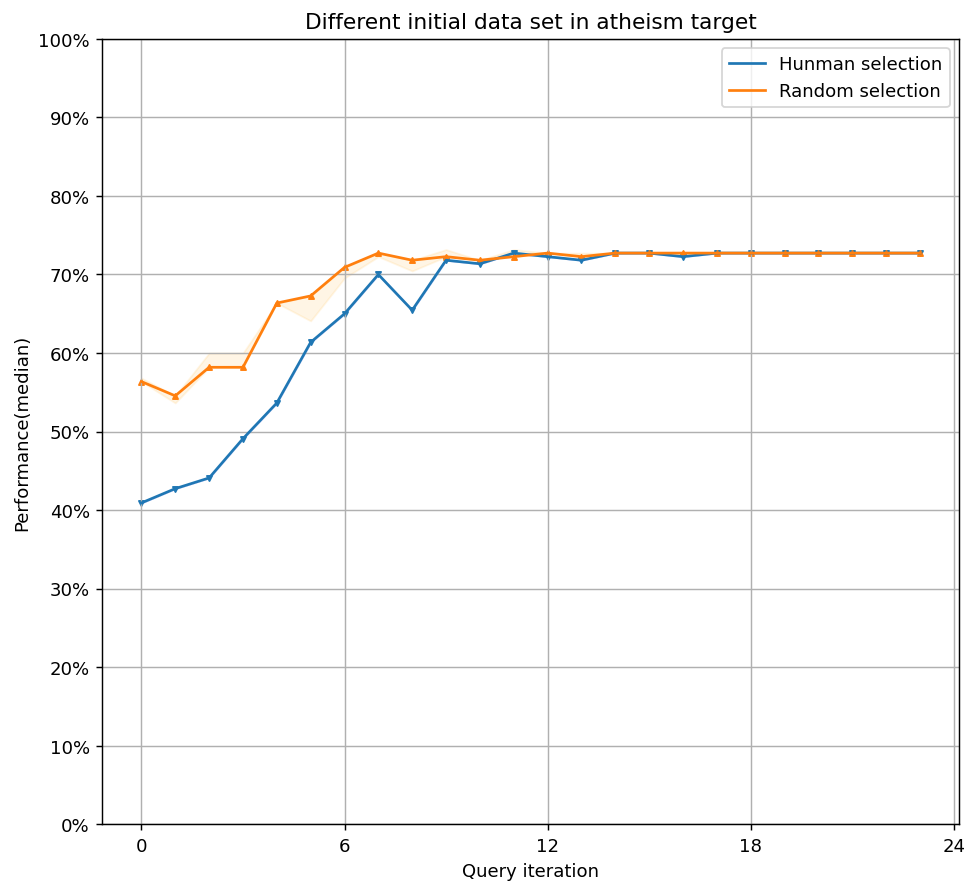

In [20]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(median_atheism1,label="Hunman selection")
ax.fill_between(range(24),min_atheism1,max_atheism1,color='blue', alpha=0.1)
ax.plot(median_atheism2,label="Random selection")
ax.fill_between(range(24),min_atheism2,max_atheism2,color='orange', alpha=0.1)

ax.scatter(range(24), median_atheism1, s=8,marker = "v")
ax.scatter(range(24), median_atheism2, s=8,marker="^")

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different initial data set in atheism target')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Performance(median)')

plt.show()

# Climate

In [44]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_climate = load_dataset(
    "tweet_eval",
    name="stance_climate",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_climate)} instances loaded")

val_dataset_climate = load_dataset(
    "tweet_eval",
    name="stance_climate",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_climate)} instances loaded")

test_dataset_climate = load_dataset(
    "tweet_eval",
    name="stance_climate",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_climate)} instances loaded")

num_classes = np.unique(train_dataset_climate['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_climate\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 355 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_climate\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 40 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_climate\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 169 instances loaded


In [45]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [46]:
active_mc_climate1= []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
#     n_labeled_examples = np.unique(train_dataset_climate['text']).size
#     training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
#     print(training_indices0)
    active_set_climate =active_huggingface_dataset(train_dataset_climate,tokenizer,'label','text')
    valid_set_climate = HuggingFaceDatasets(test_dataset_climate,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_climate.can_label = False
    active_set_climate.label([0,1,2,3,4,7,80,112,118])
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_climate,
            eval_dataset=valid_set_climate,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_climate = ActiveLearningLoop(active_set_climate,
                                 model.predict_on_dataset,
                                 heuristic, 10, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_climate=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_climate.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_climate.labelled_map,
            "Next Training set size": len(active_set_climate),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_climate.append(eval_metrics['eval_accuracy'])
    print(performance_history_climate)
    active_mc_climate1.append(performance_history_climate)
    mcrun = mcrun + 1

***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:58:44.584933Z [info     ] Start Predict                  dataset=346


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 17.70it/s]
***** Running training *****
  Num examples = 19
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:58:50.207024Z [info     ] Start Predict                  dataset=336


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 17.35it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:58:56.245109Z [info     ] Start Predict                  dataset=326


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 17.37it/s]
***** Running training *****
  Num examples = 39
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:59:03.074641Z [info     ] Start Predict                  dataset=316


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.48it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:59:08.471642Z [info     ] Start Predict                  dataset=306


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.54it/s]
***** Running training *****
  Num examples = 59
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:59:14.044717Z [info     ] Start Predict                  dataset=296


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:02<00:00, 18.18it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:59:19.522760Z [info     ] Start Predict                  dataset=286


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.64it/s]
***** Running training *****
  Num examples = 79
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:59:25.114760Z [info     ] Start Predict                  dataset=276


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 17.65it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:59:30.858318Z [info     ] Start Predict                  dataset=266


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.62it/s]
***** Running training *****
  Num examples = 99
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:59:36.854833Z [info     ] Start Predict                  dataset=256


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 18.35it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:59:42.892873Z [info     ] Start Predict                  dataset=246


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 17.26it/s]
***** Running training *****
  Num examples = 119
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:59:49.465437Z [info     ] Start Predict                  dataset=236


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.31it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T15:59:55.738553Z [info     ] Start Predict                  dataset=226


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 17.30it/s]
***** Running training *****
  Num examples = 139
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:00:02.817697Z [info     ] Start Predict                  dataset=216


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 20.16it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:00:08.731828Z [info     ] Start Predict                  dataset=206


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 18.61it/s]
***** Running training *****
  Num examples = 159
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:00:15.557352Z [info     ] Start Predict                  dataset=196


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.77it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:00:22.204870Z [info     ] Start Predict                  dataset=186


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 21.62it/s]
***** Running training *****
  Num examples = 179
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:00:28.306950Z [info     ] Start Predict                  dataset=176


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 20.22it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:00:35.139512Z [info     ] Start Predict                  dataset=166


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 20.65it/s]
***** Running training *****
  Num examples = 199
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:00:41.813074Z [info     ] Start Predict                  dataset=156


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 16.27it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:00:49.134218Z [info     ] Start Predict                  dataset=146


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 22.62it/s]
***** Running training *****
  Num examples = 219
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:00:56.651264Z [info     ] Start Predict                  dataset=136


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 19.59it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:01:04.098305Z [info     ] Start Predict                  dataset=126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 20.92it/s]
***** Running training *****
  Num examples = 239
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:01:11.354390Z [info     ] Start Predict                  dataset=116


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 20.83it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:01:19.116445Z [info     ] Start Predict                  dataset=106


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.00it/s]
***** Running training *****
  Num examples = 259
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:01:26.761446Z [info     ] Start Predict                  dataset=96


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.94it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:01:35.459130Z [info     ] Start Predict                  dataset=86


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.18it/s]
***** Running training *****
  Num examples = 279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:01:42.814685Z [info     ] Start Predict                  dataset=76


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 20.79it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:01:50.882805Z [info     ] Start Predict                  dataset=66


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 23.20it/s]
***** Running training *****
  Num examples = 299
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:01:58.247404Z [info     ] Start Predict                  dataset=56


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 18.62it/s]


[0.17159763313609466, 0.16568047337278108, 0.21301775147928995, 0.17751479289940827, 0.28402366863905326, 0.2958579881656805, 0.33727810650887574, 0.3609467455621302, 0.31952662721893493, 0.39644970414201186, 0.41420118343195267, 0.5562130177514792, 0.44970414201183434, 0.38461538461538464, 0.5088757396449705, 0.4911242603550296, 0.5739644970414202, 0.44970414201183434, 0.5976331360946746, 0.5029585798816568, 0.34911242603550297, 0.38461538461538464, 0.378698224852071, 0.5739644970414202, 0.514792899408284, 0.5029585798816568, 0.514792899408284, 0.4319526627218935, 0.5680473372781065, 0.591715976331361, 0.5266272189349113]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:02:02.584403Z [info     ] Start Predict                  dataset=346


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 18.88it/s]
***** Running training *****
  Num examples = 19
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:02:07.142924Z [info     ] Start Predict                  dataset=336


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 20.89it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:02:11.451446Z [info     ] Start Predict                  dataset=326


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 19.94it/s]
***** Running training *****
  Num examples = 39
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:02:16.059490Z [info     ] Start Predict                  dataset=316


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 19.57it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:02:20.947490Z [info     ] Start Predict                  dataset=306


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 20.22it/s]
***** Running training *****
  Num examples = 59
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:02:25.883490Z [info     ] Start Predict                  dataset=296


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 20.02it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:02:30.987061Z [info     ] Start Predict                  dataset=286


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 20.70it/s]
***** Running training *****
  Num examples = 79
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:02:35.885060Z [info     ] Start Predict                  dataset=276


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 20.80it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:02:40.973582Z [info     ] Start Predict                  dataset=266


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 23.56it/s]
***** Running training *****
  Num examples = 99
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:02:46.034708Z [info     ] Start Predict                  dataset=256


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 20.21it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:02:51.965711Z [info     ] Start Predict                  dataset=246


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 17.68it/s]
***** Running training *****
  Num examples = 119
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:02:58.115751Z [info     ] Start Predict                  dataset=236


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 20.69it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:03:04.538561Z [info     ] Start Predict                  dataset=226


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 21.33it/s]
***** Running training *****
  Num examples = 139
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:03:10.798607Z [info     ] Start Predict                  dataset=216


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 16.70it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:03:18.094284Z [info     ] Start Predict                  dataset=206


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 19.25it/s]
***** Running training *****
  Num examples = 159
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:03:24.646414Z [info     ] Start Predict                  dataset=196


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 20.02it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:03:31.261981Z [info     ] Start Predict                  dataset=186


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 25.53it/s]
***** Running training *****
  Num examples = 179
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:03:37.766018Z [info     ] Start Predict                  dataset=176


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 18.72it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:03:44.570600Z [info     ] Start Predict                  dataset=166


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 20.34it/s]
***** Running training *****
  Num examples = 199
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:03:51.455820Z [info     ] Start Predict                  dataset=156


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.35it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:03:58.477516Z [info     ] Start Predict                  dataset=146


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 19.73it/s]
***** Running training *****
  Num examples = 219
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:04:06.520859Z [info     ] Start Predict                  dataset=136


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 18.91it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:04:14.666380Z [info     ] Start Predict                  dataset=126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 22.44it/s]
***** Running training *****
  Num examples = 239
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:04:23.464951Z [info     ] Start Predict                  dataset=116


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 17.26it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:04:32.437003Z [info     ] Start Predict                  dataset=106


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 20.38it/s]
***** Running training *****
  Num examples = 259
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:04:41.188158Z [info     ] Start Predict                  dataset=96


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 19.14it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:04:50.132792Z [info     ] Start Predict                  dataset=86


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 11.32it/s]
***** Running training *****
  Num examples = 279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:04:59.302736Z [info     ] Start Predict                  dataset=76


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.98it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:05:08.700959Z [info     ] Start Predict                  dataset=66


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 24.00it/s]
***** Running training *****
  Num examples = 299
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:05:17.165997Z [info     ] Start Predict                  dataset=56


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.34it/s]


[0.17159763313609466, 0.16568047337278108, 0.21301775147928995, 0.17751479289940827, 0.28402366863905326, 0.2958579881656805, 0.33727810650887574, 0.3609467455621302, 0.31952662721893493, 0.39644970414201186, 0.41420118343195267, 0.5562130177514792, 0.44970414201183434, 0.38461538461538464, 0.5088757396449705, 0.4911242603550296, 0.5739644970414202, 0.44970414201183434, 0.5976331360946746, 0.5029585798816568, 0.34911242603550297, 0.38461538461538464, 0.378698224852071, 0.5739644970414202, 0.514792899408284, 0.5029585798816568, 0.514792899408284, 0.4319526627218935, 0.5680473372781065, 0.591715976331361, 0.5266272189349113]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:05:21.171601Z [info     ] Start Predict                  dataset=346


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 19.59it/s]
***** Running training *****
  Num examples = 19
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:05:25.474599Z [info     ] Start Predict                  dataset=336


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 20.55it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:05:30.388149Z [info     ] Start Predict                  dataset=326


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 19.84it/s]
***** Running training *****
  Num examples = 39
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:05:34.950270Z [info     ] Start Predict                  dataset=316


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 17.61it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:05:40.071266Z [info     ] Start Predict                  dataset=306


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 16.67it/s]
***** Running training *****
  Num examples = 59
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:05:45.676359Z [info     ] Start Predict                  dataset=296


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:02<00:00, 18.38it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:05:50.854878Z [info     ] Start Predict                  dataset=286


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 17.61it/s]
***** Running training *****
  Num examples = 79
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:05:56.626431Z [info     ] Start Predict                  dataset=276


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:02<00:00, 15.34it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:06:02.931484Z [info     ] Start Predict                  dataset=266


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.55it/s]
***** Running training *****
  Num examples = 99
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:06:08.536481Z [info     ] Start Predict                  dataset=256


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.92it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:06:13.923482Z [info     ] Start Predict                  dataset=246


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 19.91it/s]
***** Running training *****
  Num examples = 119
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:06:19.618482Z [info     ] Start Predict                  dataset=236


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.71it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:06:25.484483Z [info     ] Start Predict                  dataset=226


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 18.67it/s]
***** Running training *****
  Num examples = 139
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:06:31.544643Z [info     ] Start Predict                  dataset=216


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 15.43it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:06:38.619640Z [info     ] Start Predict                  dataset=206


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:01<00:00, 24.86it/s]
***** Running training *****
  Num examples = 159
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:06:44.710642Z [info     ] Start Predict                  dataset=196


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 14.93it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:06:52.017640Z [info     ] Start Predict                  dataset=186


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 19.52it/s]
***** Running training *****
  Num examples = 179
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:06:58.793734Z [info     ] Start Predict                  dataset=176


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 17.76it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:07:05.711774Z [info     ] Start Predict                  dataset=166


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 19.46it/s]
***** Running training *****
  Num examples = 199
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:07:13.020288Z [info     ] Start Predict                  dataset=156


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 25.97it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:07:19.468889Z [info     ] Start Predict                  dataset=146


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 20.08it/s]
***** Running training *****
  Num examples = 219
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:07:27.099891Z [info     ] Start Predict                  dataset=136


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 20.12it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:07:35.132418Z [info     ] Start Predict                  dataset=126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.37it/s]
***** Running training *****
  Num examples = 239
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:07:42.502989Z [info     ] Start Predict                  dataset=116


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 20.24it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:07:50.122153Z [info     ] Start Predict                  dataset=106


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.51it/s]
***** Running training *****
  Num examples = 259
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:07:58.157837Z [info     ] Start Predict                  dataset=96


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 17.07it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:08:05.699356Z [info     ] Start Predict                  dataset=86


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 20.91it/s]
***** Running training *****
  Num examples = 279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:08:14.675491Z [info     ] Start Predict                  dataset=76


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 18.62it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:08:23.688570Z [info     ] Start Predict                  dataset=66


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 17.65it/s]
***** Running training *****
  Num examples = 299
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:08:33.113617Z [info     ] Start Predict                  dataset=56


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.02it/s]


[0.17159763313609466, 0.16568047337278108, 0.21301775147928995, 0.17751479289940827, 0.28402366863905326, 0.2958579881656805, 0.33727810650887574, 0.3609467455621302, 0.31952662721893493, 0.39644970414201186, 0.41420118343195267, 0.5562130177514792, 0.44970414201183434, 0.38461538461538464, 0.5088757396449705, 0.4911242603550296, 0.5739644970414202, 0.44970414201183434, 0.5976331360946746, 0.5029585798816568, 0.34911242603550297, 0.38461538461538464, 0.378698224852071, 0.5739644970414202, 0.514792899408284, 0.5029585798816568, 0.514792899408284, 0.4319526627218935, 0.5680473372781065, 0.591715976331361, 0.5266272189349113]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:08:37.045615Z [info     ] Start Predict                  dataset=346


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:02<00:00, 19.87it/s]
***** Running training *****
  Num examples = 19
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:08:41.586186Z [info     ] Start Predict                  dataset=336


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 17.99it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:08:46.482295Z [info     ] Start Predict                  dataset=326


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 18.82it/s]
***** Running training *****
  Num examples = 39
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:08:51.075858Z [info     ] Start Predict                  dataset=316


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 20.07it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:08:55.946376Z [info     ] Start Predict                  dataset=306


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:02<00:00, 18.99it/s]
***** Running training *****
  Num examples = 59
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:01.514891Z [info     ] Start Predict                  dataset=296


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:02<00:00, 17.11it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:07.558282Z [info     ] Start Predict                  dataset=286


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 26.09it/s]
***** Running training *****
  Num examples = 79
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:11.453800Z [info     ] Start Predict                  dataset=276


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 27.77it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:15.227320Z [info     ] Start Predict                  dataset=266


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 29.26it/s]
***** Running training *****
  Num examples = 99
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:18.902317Z [info     ] Start Predict                  dataset=256


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.28it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:22.666455Z [info     ] Start Predict                  dataset=246


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 31.28it/s]
***** Running training *****
  Num examples = 119
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:26.373454Z [info     ] Start Predict                  dataset=236


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 27.47it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:30.686453Z [info     ] Start Predict                  dataset=226


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 29.00it/s]
***** Running training *****
  Num examples = 139
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:34.972452Z [info     ] Start Predict                  dataset=216


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.01it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:38.790451Z [info     ] Start Predict                  dataset=206


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.38it/s]
***** Running training *****
  Num examples = 159
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:43.113454Z [info     ] Start Predict                  dataset=196


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 27.34it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:47.887300Z [info     ] Start Predict                  dataset=186


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.65it/s]
***** Running training *****
  Num examples = 179
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:51.936858Z [info     ] Start Predict                  dataset=176


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.79it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:09:56.068859Z [info     ] Start Predict                  dataset=166


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 32.26it/s]
***** Running training *****
  Num examples = 199
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:00.354376Z [info     ] Start Predict                  dataset=156


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.61it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:04.612375Z [info     ] Start Predict                  dataset=146


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.99it/s]
***** Running training *****
  Num examples = 219
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:09.090375Z [info     ] Start Predict                  dataset=136


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.00it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:13.844376Z [info     ] Start Predict                  dataset=126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 30.13it/s]
***** Running training *****
  Num examples = 239
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:18.946375Z [info     ] Start Predict                  dataset=116


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 29.88it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:24.283376Z [info     ] Start Predict                  dataset=106


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 28.69it/s]
***** Running training *****
  Num examples = 259
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:30.475382Z [info     ] Start Predict                  dataset=96


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 25.42it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:36.636892Z [info     ] Start Predict                  dataset=86


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 35.14it/s]
***** Running training *****
  Num examples = 279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:41.491892Z [info     ] Start Predict                  dataset=76


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.60it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:46.444343Z [info     ] Start Predict                  dataset=66


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.48it/s]
***** Running training *****
  Num examples = 299
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:51.455343Z [info     ] Start Predict                  dataset=56


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 33.65it/s]


[0.17159763313609466, 0.16568047337278108, 0.21301775147928995, 0.17751479289940827, 0.28402366863905326, 0.2958579881656805, 0.33727810650887574, 0.3609467455621302, 0.31952662721893493, 0.39644970414201186, 0.41420118343195267, 0.5562130177514792, 0.44970414201183434, 0.38461538461538464, 0.5088757396449705, 0.4911242603550296, 0.5739644970414202, 0.44970414201183434, 0.5976331360946746, 0.5029585798816568, 0.34911242603550297, 0.38461538461538464, 0.378698224852071, 0.5739644970414202, 0.514792899408284, 0.5029585798816568, 0.514792899408284, 0.4319526627218935, 0.5680473372781065, 0.591715976331361, 0.5266272189349113]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:54.138372Z [info     ] Start Predict                  dataset=346


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.82it/s]
***** Running training *****
  Num examples = 19
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:56.812342Z [info     ] Start Predict                  dataset=336


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.60it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:10:59.574403Z [info     ] Start Predict                  dataset=326


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 27.21it/s]
***** Running training *****
  Num examples = 39
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:03.007401Z [info     ] Start Predict                  dataset=316


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 27.74it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:06.573955Z [info     ] Start Predict                  dataset=306


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 28.61it/s]
***** Running training *****
  Num examples = 59
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:10.137954Z [info     ] Start Predict                  dataset=296


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 29.52it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:13.680513Z [info     ] Start Predict                  dataset=286


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 30.02it/s]
***** Running training *****
  Num examples = 79
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:17.311510Z [info     ] Start Predict                  dataset=276


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 31.11it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:20.679507Z [info     ] Start Predict                  dataset=266


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 34.84it/s]
***** Running training *****
  Num examples = 99
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:24.353690Z [info     ] Start Predict                  dataset=256


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 34.22it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:28.309744Z [info     ] Start Predict                  dataset=246


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 27.36it/s]
***** Running training *****
  Num examples = 119
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:32.517779Z [info     ] Start Predict                  dataset=236


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.00it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:36.221780Z [info     ] Start Predict                  dataset=226


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 29.74it/s]
***** Running training *****
  Num examples = 139
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:40.423776Z [info     ] Start Predict                  dataset=216


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.17it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:44.262778Z [info     ] Start Predict                  dataset=206


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 34.12it/s]
***** Running training *****
  Num examples = 159
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:48.069995Z [info     ] Start Predict                  dataset=196


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:51.976994Z [info     ] Start Predict                  dataset=186


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.85it/s]
***** Running training *****
  Num examples = 179
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:11:56.599168Z [info     ] Start Predict                  dataset=176


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 23.38it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:12:01.857214Z [info     ] Start Predict                  dataset=166


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 31.78it/s]
***** Running training *****
  Num examples = 199
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:12:06.204046Z [info     ] Start Predict                  dataset=156


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 34.01it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:12:10.589043Z [info     ] Start Predict                  dataset=146


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.93it/s]
***** Running training *****
  Num examples = 219
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:12:15.088046Z [info     ] Start Predict                  dataset=136


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.01it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:12:19.560044Z [info     ] Start Predict                  dataset=126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 34.63it/s]
***** Running training *****
  Num examples = 239
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:12:24.129043Z [info     ] Start Predict                  dataset=116


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 31.19it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:12:29.114047Z [info     ] Start Predict                  dataset=106


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.26it/s]
***** Running training *****
  Num examples = 259
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:12:34.196044Z [info     ] Start Predict                  dataset=96


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 31.66it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:12:39.412045Z [info     ] Start Predict                  dataset=86


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 30.56it/s]
***** Running training *****
  Num examples = 279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:12:45.515609Z [info     ] Start Predict                  dataset=76


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.18it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:12:51.544610Z [info     ] Start Predict                  dataset=66


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.09it/s]
***** Running training *****
  Num examples = 299
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:12:57.194610Z [info     ] Start Predict                  dataset=56


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 30.57it/s]


[0.17159763313609466, 0.16568047337278108, 0.21301775147928995, 0.17751479289940827, 0.28402366863905326, 0.2958579881656805, 0.33727810650887574, 0.3609467455621302, 0.31952662721893493, 0.39644970414201186, 0.41420118343195267, 0.5562130177514792, 0.44970414201183434, 0.38461538461538464, 0.5088757396449705, 0.4911242603550296, 0.5739644970414202, 0.44970414201183434, 0.5976331360946746, 0.5029585798816568, 0.34911242603550297, 0.38461538461538464, 0.378698224852071, 0.5739644970414202, 0.514792899408284, 0.5029585798816568, 0.514792899408284, 0.4319526627218935, 0.5680473372781065, 0.591715976331361, 0.5266272189349113]


In [47]:
active_mc_climate2 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
#     n_labeled_examples = np.unique(train_dataset_climate['text']).size
#     training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
#     print(training_indices0)
    active_set_climate =active_huggingface_dataset(train_dataset_climate,tokenizer,'label','text')
    valid_set_climate = HuggingFaceDatasets(test_dataset_climate,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_climate.can_label = False
    active_set_climate.label_randomly(9)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_climate,
            eval_dataset=valid_set_climate,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_climate = ActiveLearningLoop(active_set_climate,
                                 model.predict_on_dataset,
                                 heuristic, 10, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_climate=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_climate.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_climate.labelled_map,
            "Next Training set size": len(active_set_climate),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_climate.append(eval_metrics['eval_accuracy'])
    print(performance_history_climate)
    active_mc_climate2.append(performance_history_climate)
    mcrun = mcrun + 1

D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:00.252609Z [info     ] Start Predict                  dataset=346


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 28.83it/s]
***** Running training *****
  Num examples = 19
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:03.466608Z [info     ] Start Predict                  dataset=336


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 25.38it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:10.225440Z [info     ] Start Predict                  dataset=326


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 32.49it/s]
***** Running training *****
  Num examples = 39
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:15.342960Z [info     ] Start Predict                  dataset=316


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 32.34it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:20.043667Z [info     ] Start Predict                  dataset=306


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.58it/s]
***** Running training *****
  Num examples = 59
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:25.874694Z [info     ] Start Predict                  dataset=296


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 31.22it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:30.210825Z [info     ] Start Predict                  dataset=286


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.76it/s]
***** Running training *****
  Num examples = 79
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:34.841798Z [info     ] Start Predict                  dataset=276


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 32.38it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:39.794243Z [info     ] Start Predict                  dataset=266


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 31.28it/s]
***** Running training *****
  Num examples = 99
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:44.467139Z [info     ] Start Predict                  dataset=256


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.86it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:48.655191Z [info     ] Start Predict                  dataset=246


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 31.70it/s]
***** Running training *****
  Num examples = 119
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:53.622189Z [info     ] Start Predict                  dataset=236


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.33it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:13:58.550289Z [info     ] Start Predict                  dataset=226


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.73it/s]
***** Running training *****
  Num examples = 139
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:02.423290Z [info     ] Start Predict                  dataset=216


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.45it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:06.329291Z [info     ] Start Predict                  dataset=206


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.68it/s]
***** Running training *****
  Num examples = 159
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:10.355301Z [info     ] Start Predict                  dataset=196


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 32.89it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:14.469300Z [info     ] Start Predict                  dataset=186


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 31.91it/s]
***** Running training *****
  Num examples = 179
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:18.612331Z [info     ] Start Predict                  dataset=176


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 31.75it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:22.779301Z [info     ] Start Predict                  dataset=166


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 33.65it/s]
***** Running training *****
  Num examples = 199
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:27.036858Z [info     ] Start Predict                  dataset=156


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 30.86it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:32.207854Z [info     ] Start Predict                  dataset=146


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 26.91it/s]
***** Running training *****
  Num examples = 219
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:37.737856Z [info     ] Start Predict                  dataset=136


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 31.05it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:42.545370Z [info     ] Start Predict                  dataset=126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 31.56it/s]
***** Running training *****
  Num examples = 239
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:47.265370Z [info     ] Start Predict                  dataset=116


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 30.43it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:53.025371Z [info     ] Start Predict                  dataset=106


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 25.27it/s]
***** Running training *****
  Num examples = 259
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:14:58.841382Z [info     ] Start Predict                  dataset=96


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 29.70it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:03.827384Z [info     ] Start Predict                  dataset=86


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 34.59it/s]
***** Running training *****
  Num examples = 279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:08.997382Z [info     ] Start Predict                  dataset=76


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 34.72it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:14.306381Z [info     ] Start Predict                  dataset=66


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.83it/s]
***** Running training *****
  Num examples = 299
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:19.636896Z [info     ] Start Predict                  dataset=56


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 31.39it/s]


[0.2485207100591716, 0.21301775147928995, 0.26627218934911245, 0.21893491124260356, 0.3668639053254438, 0.3431952662721893, 0.3668639053254438, 0.46745562130177515, 0.3668639053254438, 0.38461538461538464, 0.47928994082840237, 0.5325443786982249, 0.47928994082840237, 0.5680473372781065, 0.5502958579881657, 0.5207100591715976, 0.3431952662721893, 0.514792899408284, 0.39644970414201186, 0.5088757396449705, 0.41420118343195267, 0.5029585798816568, 0.4378698224852071, 0.5680473372781065, 0.4260355029585799, 0.47928994082840237, 0.5266272189349113, 0.39644970414201186, 0.591715976331361, 0.6686390532544378, 0.6449704142011834]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:22.551913Z [info     ] Start Predict                  dataset=346


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 31.75it/s]
***** Running training *****
  Num examples = 19
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:25.314911Z [info     ] Start Predict                  dataset=336


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 31.41it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:28.219912Z [info     ] Start Predict                  dataset=326


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 32.49it/s]
***** Running training *****
  Num examples = 39
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:31.158911Z [info     ] Start Predict                  dataset=316


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 26.16it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:34.888911Z [info     ] Start Predict                  dataset=306


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 25.32it/s]
***** Running training *****
  Num examples = 59
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:39.389433Z [info     ] Start Predict                  dataset=296


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 24.58it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:43.535431Z [info     ] Start Predict                  dataset=286


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 29.63it/s]
***** Running training *****
  Num examples = 79
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:46.814433Z [info     ] Start Predict                  dataset=276


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 32.71it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:50.159174Z [info     ] Start Predict                  dataset=266


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.20it/s]
***** Running training *****
  Num examples = 99
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:53.638176Z [info     ] Start Predict                  dataset=256


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.92it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:15:57.718173Z [info     ] Start Predict                  dataset=246


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:01<00:00, 25.49it/s]
***** Running training *****
  Num examples = 119
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:02.242175Z [info     ] Start Predict                  dataset=236


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 33.15it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:06.224174Z [info     ] Start Predict                  dataset=226


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.03it/s]
***** Running training *****
  Num examples = 139
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:10.185174Z [info     ] Start Predict                  dataset=216


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 31.07it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:14.101174Z [info     ] Start Predict                  dataset=206


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.22it/s]
***** Running training *****
  Num examples = 159
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:17.952174Z [info     ] Start Predict                  dataset=196


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 30.86it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:22.232580Z [info     ] Start Predict                  dataset=186


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 31.83it/s]
***** Running training *****
  Num examples = 179
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:26.852583Z [info     ] Start Predict                  dataset=176


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 28.46it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:32.176176Z [info     ] Start Predict                  dataset=166


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 32.41it/s]
***** Running training *****
  Num examples = 199
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:36.967222Z [info     ] Start Predict                  dataset=156


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.55it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:42.177853Z [info     ] Start Predict                  dataset=146


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 25.82it/s]
***** Running training *****
  Num examples = 219
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:47.071368Z [info     ] Start Predict                  dataset=136


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:51.582700Z [info     ] Start Predict                  dataset=126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 32.85it/s]
***** Running training *****
  Num examples = 239
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:16:56.049666Z [info     ] Start Predict                  dataset=116


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 33.86it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:00.934664Z [info     ] Start Predict                  dataset=106


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.82it/s]
***** Running training *****
  Num examples = 259
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:06.033667Z [info     ] Start Predict                  dataset=96


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 30.53it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:11.365674Z [info     ] Start Predict                  dataset=86


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.25it/s]
***** Running training *****
  Num examples = 279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:17.220268Z [info     ] Start Predict                  dataset=76


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.80it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:23.688789Z [info     ] Start Predict                  dataset=66


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 27.36it/s]
***** Running training *****
  Num examples = 299
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:30.172874Z [info     ] Start Predict                  dataset=56


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 31.96it/s]


[0.1893491124260355, 0.1952662721893491, 0.20710059171597633, 0.20710059171597633, 0.2485207100591716, 0.2603550295857988, 0.31952662721893493, 0.38461538461538464, 0.3431952662721893, 0.34911242603550297, 0.4556213017751479, 0.4970414201183432, 0.39644970414201186, 0.41420118343195267, 0.39644970414201186, 0.4260355029585799, 0.40828402366863903, 0.5680473372781065, 0.39644970414201186, 0.48520710059171596, 0.4437869822485207, 0.3254437869822485, 0.378698224852071, 0.3431952662721893, 0.5443786982248521, 0.4911242603550296, 0.41420118343195267, 0.44970414201183434, 0.5680473372781065, 0.5680473372781065, 0.5857988165680473]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:33.008874Z [info     ] Start Predict                  dataset=346


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 30.68it/s]
***** Running training *****
  Num examples = 19
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:35.935931Z [info     ] Start Predict                  dataset=336


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 30.22it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:38.820932Z [info     ] Start Predict                  dataset=326


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 31.49it/s]
***** Running training *****
  Num examples = 39
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:41.867857Z [info     ] Start Predict                  dataset=316


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 31.42it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:45.026920Z [info     ] Start Predict                  dataset=306


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.97it/s]
***** Running training *****
  Num examples = 59
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:48.216918Z [info     ] Start Predict                  dataset=296


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 31.28it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:51.530920Z [info     ] Start Predict                  dataset=286


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 31.28it/s]
***** Running training *****
  Num examples = 79
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:54.864917Z [info     ] Start Predict                  dataset=276


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 31.65it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:17:58.559918Z [info     ] Start Predict                  dataset=266


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 31.60it/s]
***** Running training *****
  Num examples = 99
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:02.257024Z [info     ] Start Predict                  dataset=256


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 30.77it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:05.909025Z [info     ] Start Predict                  dataset=246


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.24it/s]
***** Running training *****
  Num examples = 119
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:09.751590Z [info     ] Start Predict                  dataset=236


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 26.86it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:14.831630Z [info     ] Start Predict                  dataset=226


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:01<00:00, 26.32it/s]
***** Running training *****
  Num examples = 139
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:20.272718Z [info     ] Start Predict                  dataset=216


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.30it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:24.629956Z [info     ] Start Predict                  dataset=206


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.26it/s]
***** Running training *****
  Num examples = 159
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:28.568927Z [info     ] Start Predict                  dataset=196


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 32.34it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:32.749925Z [info     ] Start Predict                  dataset=186


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.29it/s]
***** Running training *****
  Num examples = 179
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:37.208314Z [info     ] Start Predict                  dataset=176


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 31.12it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:41.686282Z [info     ] Start Predict                  dataset=166


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 32.31it/s]
***** Running training *****
  Num examples = 199
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:46.252285Z [info     ] Start Predict                  dataset=156


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.96it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:50.657777Z [info     ] Start Predict                  dataset=146


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.55it/s]
***** Running training *****
  Num examples = 219
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:18:56.215848Z [info     ] Start Predict                  dataset=136


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 24.82it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:19:04.642989Z [info     ] Start Predict                  dataset=126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 13.03it/s]
***** Running training *****
  Num examples = 239
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:19:12.880989Z [info     ] Start Predict                  dataset=116


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 24.67it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:19:19.165989Z [info     ] Start Predict                  dataset=106


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 26.12it/s]
***** Running training *****
  Num examples = 259
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:19:25.609031Z [info     ] Start Predict                  dataset=96


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 20.69it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:19:33.065615Z [info     ] Start Predict                  dataset=86


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 27.36it/s]
***** Running training *****
  Num examples = 279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:19:39.589176Z [info     ] Start Predict                  dataset=76


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 26.39it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:19:45.237724Z [info     ] Start Predict                  dataset=66


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.71it/s]
***** Running training *****
  Num examples = 299
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:19:51.588852Z [info     ] Start Predict                  dataset=56


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 21.67it/s]


[0.1893491124260355, 0.1952662721893491, 0.20710059171597633, 0.20710059171597633, 0.2485207100591716, 0.2603550295857988, 0.31952662721893493, 0.38461538461538464, 0.3431952662721893, 0.34911242603550297, 0.4556213017751479, 0.4970414201183432, 0.39644970414201186, 0.41420118343195267, 0.39644970414201186, 0.4260355029585799, 0.40828402366863903, 0.5680473372781065, 0.39644970414201186, 0.48520710059171596, 0.4437869822485207, 0.3254437869822485, 0.378698224852071, 0.3431952662721893, 0.5443786982248521, 0.4911242603550296, 0.41420118343195267, 0.44970414201183434, 0.5680473372781065, 0.5680473372781065, 0.5857988165680473]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:19:55.315420Z [info     ] Start Predict                  dataset=346


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 25.48it/s]
***** Running training *****
  Num examples = 19
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:19:58.570921Z [info     ] Start Predict                  dataset=336


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 32.99it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:01.449923Z [info     ] Start Predict                  dataset=326


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 32.23it/s]
***** Running training *****
  Num examples = 39
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:04.409924Z [info     ] Start Predict                  dataset=316


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 20.97it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:09.691479Z [info     ] Start Predict                  dataset=306


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 24.97it/s]
***** Running training *****
  Num examples = 59
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:13.718476Z [info     ] Start Predict                  dataset=296


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 30.18it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:17.095477Z [info     ] Start Predict                  dataset=286


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 28.80it/s]
***** Running training *****
  Num examples = 79
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:20.681318Z [info     ] Start Predict                  dataset=276


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 26.76it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:24.680949Z [info     ] Start Predict                  dataset=266


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.73it/s]
***** Running training *****
  Num examples = 99
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:28.355949Z [info     ] Start Predict                  dataset=256


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.01it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:32.174463Z [info     ] Start Predict                  dataset=246


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.12it/s]
***** Running training *****
  Num examples = 119
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:35.904409Z [info     ] Start Predict                  dataset=236


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 32.97it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:39.601692Z [info     ] Start Predict                  dataset=226


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.19it/s]
***** Running training *****
  Num examples = 139
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:44.325691Z [info     ] Start Predict                  dataset=216


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 27.38it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:49.415694Z [info     ] Start Predict                  dataset=206


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26.56it/s]
***** Running training *****
  Num examples = 159
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:54.564695Z [info     ] Start Predict                  dataset=196


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 24.78it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:20:59.490642Z [info     ] Start Predict                  dataset=186


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 29.13it/s]
***** Running training *****
  Num examples = 179
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:21:04.789691Z [info     ] Start Predict                  dataset=176


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 23.94it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:21:09.511690Z [info     ] Start Predict                  dataset=166


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 20.09it/s]
***** Running training *****
  Num examples = 199
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:21:14.970213Z [info     ] Start Predict                  dataset=156


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.66it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:21:20.050756Z [info     ] Start Predict                  dataset=146


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.55it/s]
***** Running training *****
  Num examples = 219
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:21:24.722757Z [info     ] Start Predict                  dataset=136


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 29.36it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:21:29.516755Z [info     ] Start Predict                  dataset=126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 34.78it/s]
***** Running training *****
  Num examples = 239
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:21:34.809252Z [info     ] Start Predict                  dataset=116


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 28.74it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:21:40.360806Z [info     ] Start Predict                  dataset=106


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.79it/s]
***** Running training *****
  Num examples = 259
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:21:46.179663Z [info     ] Start Predict                  dataset=96


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.58it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:21:51.997217Z [info     ] Start Predict                  dataset=86


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 26.96it/s]
***** Running training *****
  Num examples = 279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:21:57.452212Z [info     ] Start Predict                  dataset=76


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 33.45it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:02.624212Z [info     ] Start Predict                  dataset=66


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.09it/s]
***** Running training *****
  Num examples = 299
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:08.058211Z [info     ] Start Predict                  dataset=56


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 33.82it/s]


[0.1893491124260355, 0.1952662721893491, 0.20710059171597633, 0.20710059171597633, 0.2485207100591716, 0.2603550295857988, 0.31952662721893493, 0.38461538461538464, 0.3431952662721893, 0.34911242603550297, 0.4556213017751479, 0.4970414201183432, 0.39644970414201186, 0.41420118343195267, 0.39644970414201186, 0.4260355029585799, 0.40828402366863903, 0.5680473372781065, 0.39644970414201186, 0.48520710059171596, 0.4437869822485207, 0.3254437869822485, 0.378698224852071, 0.3431952662721893, 0.5443786982248521, 0.4911242603550296, 0.41420118343195267, 0.44970414201183434, 0.5680473372781065, 0.5680473372781065, 0.5857988165680473]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:10.861210Z [info     ] Start Predict                  dataset=346


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.39it/s]
***** Running training *****
  Num examples = 19
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:13.646765Z [info     ] Start Predict                  dataset=336


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 26.47it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:17.178764Z [info     ] Start Predict                  dataset=326


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 25.58it/s]
***** Running training *****
  Num examples = 39
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 5


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:20.777767Z [info     ] Start Predict                  dataset=316


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 24.48it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:24.584761Z [info     ] Start Predict                  dataset=306


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 30.42it/s]
***** Running training *****
  Num examples = 59
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 8


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:27.884763Z [info     ] Start Predict                  dataset=296


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 32.69it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:30.965764Z [info     ] Start Predict                  dataset=286


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.18it/s]
***** Running training *****
  Num examples = 79
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:34.090762Z [info     ] Start Predict                  dataset=276


100%|██████████████████████████████████████████████████████████████████████████████████| 35/35 [00:01<00:00, 33.05it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:37.557763Z [info     ] Start Predict                  dataset=266


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 34.13it/s]
***** Running training *****
  Num examples = 99
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 13


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:41.044899Z [info     ] Start Predict                  dataset=256


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.42it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:44.555899Z [info     ] Start Predict                  dataset=246


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.16it/s]
***** Running training *****
  Num examples = 119
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 15


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:48.408408Z [info     ] Start Predict                  dataset=236


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 34.03it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:52.337931Z [info     ] Start Predict                  dataset=226


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.32it/s]
***** Running training *****
  Num examples = 139
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 18


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:22:57.283930Z [info     ] Start Predict                  dataset=216


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:01<00:00, 24.04it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:23:02.763062Z [info     ] Start Predict                  dataset=206


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.87it/s]
***** Running training *****
  Num examples = 159
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:23:06.681180Z [info     ] Start Predict                  dataset=196


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 32.39it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:23:10.850068Z [info     ] Start Predict                  dataset=186


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.53it/s]
***** Running training *****
  Num examples = 179
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 23


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:23:15.170062Z [info     ] Start Predict                  dataset=176


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 29.81it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:23:19.488062Z [info     ] Start Predict                  dataset=166


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 31.11it/s]
***** Running training *****
  Num examples = 199
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 25


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:23:23.720111Z [info     ] Start Predict                  dataset=156


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 33.84it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:23:28.330116Z [info     ] Start Predict                  dataset=146


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 26.24it/s]
***** Running training *****
  Num examples = 219
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 28


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:23:33.691114Z [info     ] Start Predict                  dataset=136


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 31.72it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:23:38.357628Z [info     ] Start Predict                  dataset=126


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 30.02it/s]
***** Running training *****
  Num examples = 239
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 30


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:23:43.472628Z [info     ] Start Predict                  dataset=116


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 32.75it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:23:48.947203Z [info     ] Start Predict                  dataset=106


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 29.72it/s]
***** Running training *****
  Num examples = 259
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 33


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:23:53.985233Z [info     ] Start Predict                  dataset=96


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 32.34it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:24:00.057233Z [info     ] Start Predict                  dataset=86


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.03it/s]
***** Running training *****
  Num examples = 279
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 35


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:24:05.482238Z [info     ] Start Predict                  dataset=76


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 25.91it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:24:13.628235Z [info     ] Start Predict                  dataset=66


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 21.90it/s]
***** Running training *****
  Num examples = 299
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 38


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 169
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T16:24:22.887762Z [info     ] Start Predict                  dataset=56


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 17.95it/s]


[0.1893491124260355, 0.1952662721893491, 0.20710059171597633, 0.20710059171597633, 0.2485207100591716, 0.2603550295857988, 0.31952662721893493, 0.38461538461538464, 0.3431952662721893, 0.34911242603550297, 0.4556213017751479, 0.4970414201183432, 0.39644970414201186, 0.41420118343195267, 0.39644970414201186, 0.4260355029585799, 0.40828402366863903, 0.5680473372781065, 0.39644970414201186, 0.48520710059171596, 0.4437869822485207, 0.3254437869822485, 0.378698224852071, 0.3431952662721893, 0.5443786982248521, 0.4911242603550296, 0.41420118343195267, 0.44970414201183434, 0.5680473372781065, 0.5680473372781065, 0.5857988165680473]


In [48]:
median_climate1, min_climate1,max_climate1 = calculate(active_mc_climate1)

In [49]:
median_climate2, min_climate2,max_climate2 = calculate(active_mc_climate2)

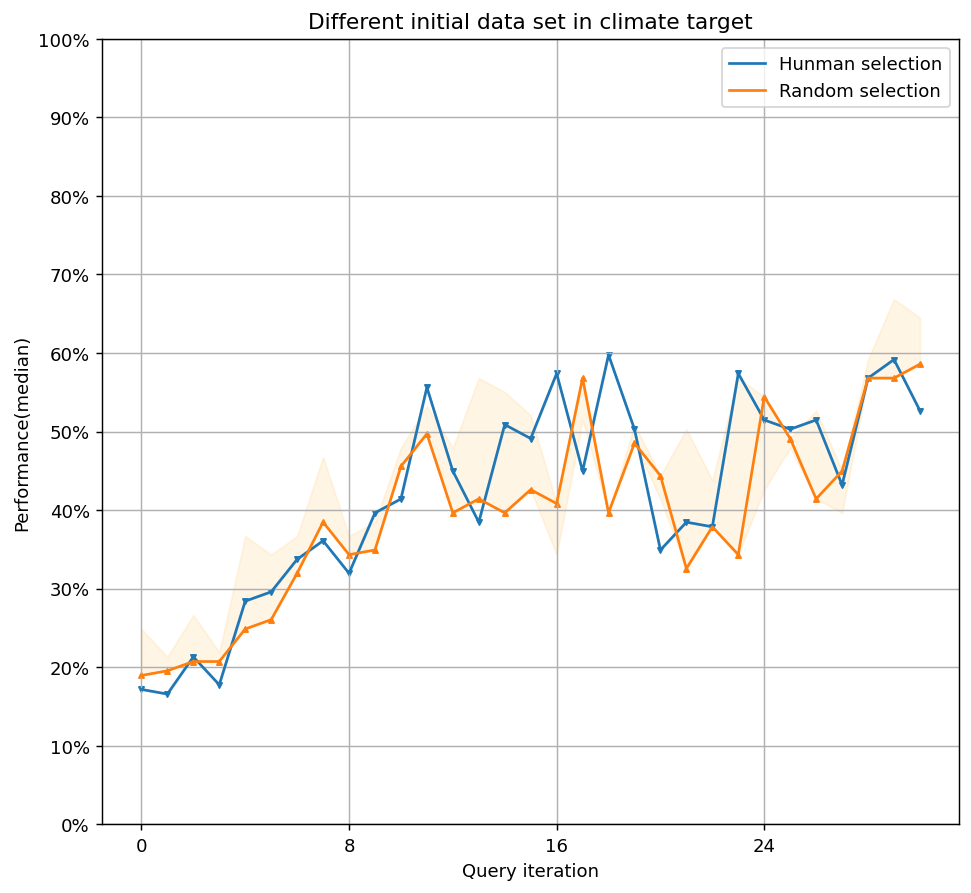

In [50]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(median_climate1,label="Hunman selection")
ax.fill_between(range(31),min_climate1,max_climate1,color='blue', alpha=0.1)
ax.plot(median_climate2,label="Random selection")
ax.fill_between(range(31),min_climate2,max_climate2,color='orange', alpha=0.1)

ax.scatter(range(31), median_climate1, s=8,marker = "v")
ax.scatter(range(31), median_climate2, s=8,marker="^")

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different initial data set in climate target')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Performance(median)')

plt.show()

# Feminist

In [28]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_feminist = load_dataset(
    "tweet_eval",
    name="stance_feminist",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_feminist)} instances loaded")

val_dataset_feminist = load_dataset(
    "tweet_eval",
    name="stance_feminist",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_feminist)} instances loaded")

test_dataset_feminist = load_dataset(
    "tweet_eval",
    name="stance_feminist",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_feminist)} instances loaded")

num_classes = np.unique(train_dataset_feminist['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_feminist\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 597 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_feminist\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 67 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_feminist\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 285 instances loaded


In [29]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [30]:
active_mc_feminist1 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
#     n_labeled_examples = np.unique(train_dataset_feminist['text']).size
#     training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
#     print(training_indices0)
    active_set_feminist =active_huggingface_dataset(train_dataset_feminist,tokenizer,'label','text')
    valid_set_feminist = HuggingFaceDatasets(test_dataset_feminist,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_feminist.can_label = False
    active_set_feminist.label([0,1,2,3,4,5,6,7,10])
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_feminist,
            eval_dataset=valid_set_feminist,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_feminist = ActiveLearningLoop(active_set_feminist,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_feminist=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_feminist.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_feminist.labelled_map,
            "Next Training set size": len(active_set_feminist),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_feminist.append(eval_metrics['eval_accuracy'])
    print(performance_history_feminist)
    active_mc_feminist1.append(performance_history_feminist)
    mcrun = mcrun + 1

***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:32:20.691804Z [info     ] Start Predict                  dataset=588


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 33.18it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:32:25.115084Z [info     ] Start Predict                  dataset=568


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 32.33it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:32:29.746085Z [info     ] Start Predict                  dataset=548


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 32.53it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:32:34.516085Z [info     ] Start Predict                  dataset=528


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 32.58it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:32:39.638083Z [info     ] Start Predict                  dataset=508


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.18it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:32:44.797111Z [info     ] Start Predict                  dataset=488


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 33.26it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:32:50.089081Z [info     ] Start Predict                  dataset=468


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 32.45it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:32:55.667082Z [info     ] Start Predict                  dataset=448


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 32.77it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:33:01.525017Z [info     ] Start Predict                  dataset=428


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.93it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:33:07.607534Z [info     ] Start Predict                  dataset=408


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 32.21it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:33:14.372562Z [info     ] Start Predict                  dataset=388


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.11it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:33:20.665611Z [info     ] Start Predict                  dataset=368


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 32.81it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:33:27.210580Z [info     ] Start Predict                  dataset=348


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.61it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:33:34.559104Z [info     ] Start Predict                  dataset=328


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 32.13it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:33:41.468098Z [info     ] Start Predict                  dataset=308


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.30it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:33:48.409097Z [info     ] Start Predict                  dataset=288


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.09it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:33:55.486132Z [info     ] Start Predict                  dataset=268


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.69it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:34:03.022683Z [info     ] Start Predict                  dataset=248


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 32.80it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:34:11.029008Z [info     ] Start Predict                  dataset=228


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.33it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:34:18.658824Z [info     ] Start Predict                  dataset=208


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.62it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:34:26.473823Z [info     ] Start Predict                  dataset=188


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.52it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:34:34.565822Z [info     ] Start Predict                  dataset=168


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 33.39it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:34:42.798849Z [info     ] Start Predict                  dataset=148


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.75it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:34:51.154699Z [info     ] Start Predict                  dataset=128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 32.13it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:35:00.162697Z [info     ] Start Predict                  dataset=108


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.98it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:35:08.941114Z [info     ] Start Predict                  dataset=88


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.43it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:35:17.950114Z [info     ] Start Predict                  dataset=68


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 35.16it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:35:27.120112Z [info     ] Start Predict                  dataset=48


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 33.15it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:35:36.512116Z [info     ] Start Predict                  dataset=28


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 37.74it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:35:45.967172Z [info     ] Start Predict                  dataset=8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


[0.4, 0.40350877192982454, 0.40350877192982454, 0.4982456140350877, 0.4982456140350877, 0.5543859649122806, 0.5754385964912281, 0.6, 0.6210526315789474, 0.6175438596491228, 0.6175438596491228, 0.631578947368421, 0.6385964912280702, 0.6070175438596491, 0.6350877192982456, 0.624561403508772, 0.6421052631578947, 0.6175438596491228, 0.6175438596491228, 0.6385964912280702, 0.6350877192982456, 0.631578947368421, 0.624561403508772, 0.6350877192982456, 0.6421052631578947, 0.6280701754385964, 0.631578947368421, 0.6421052631578947, 0.6350877192982456, 0.6421052631578947, 0.6491228070175439]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:35:49.767171Z [info     ] Start Predict                  dataset=588


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 33.26it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:35:54.188256Z [info     ] Start Predict                  dataset=568


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 32.75it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:35:59.481223Z [info     ] Start Predict                  dataset=548


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 32.63it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:36:04.337951Z [info     ] Start Predict                  dataset=528


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 32.93it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:36:09.354241Z [info     ] Start Predict                  dataset=508


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.09it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:36:14.712241Z [info     ] Start Predict                  dataset=488


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 32.63it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:36:20.081934Z [info     ] Start Predict                  dataset=468


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 33.26it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:36:25.575979Z [info     ] Start Predict                  dataset=448


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:36:31.477979Z [info     ] Start Predict                  dataset=428


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.99it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:36:37.335980Z [info     ] Start Predict                  dataset=408


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.05it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:36:43.541010Z [info     ] Start Predict                  dataset=388


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.78it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:36:50.102621Z [info     ] Start Predict                  dataset=368


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 32.72it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:36:56.638623Z [info     ] Start Predict                  dataset=348


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.14it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:37:03.193566Z [info     ] Start Predict                  dataset=328


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 32.72it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:37:09.988567Z [info     ] Start Predict                  dataset=308


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.53it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:37:17.027596Z [info     ] Start Predict                  dataset=288


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.43it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:37:24.442125Z [info     ] Start Predict                  dataset=268


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.56it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:37:31.855123Z [info     ] Start Predict                  dataset=248


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 32.80it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:37:39.313122Z [info     ] Start Predict                  dataset=228


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.56it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:37:47.315876Z [info     ] Start Predict                  dataset=208


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.44it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:37:55.248418Z [info     ] Start Predict                  dataset=188


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.04it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:38:03.544418Z [info     ] Start Predict                  dataset=168


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 32.36it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:38:11.825966Z [info     ] Start Predict                  dataset=148


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.17it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:38:20.114967Z [info     ] Start Predict                  dataset=128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 32.92it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:38:28.629965Z [info     ] Start Predict                  dataset=108


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.10it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:38:37.396966Z [info     ] Start Predict                  dataset=88


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.43it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:38:46.502510Z [info     ] Start Predict                  dataset=68


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 35.16it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:38:55.672513Z [info     ] Start Predict                  dataset=48


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 32.97it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:39:04.990147Z [info     ] Start Predict                  dataset=28


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36.36it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:39:14.368149Z [info     ] Start Predict                  dataset=8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.03it/s]


[0.4, 0.40350877192982454, 0.40350877192982454, 0.4982456140350877, 0.4982456140350877, 0.5543859649122806, 0.5754385964912281, 0.6, 0.6210526315789474, 0.6175438596491228, 0.6175438596491228, 0.631578947368421, 0.6385964912280702, 0.6070175438596491, 0.6350877192982456, 0.624561403508772, 0.6421052631578947, 0.6175438596491228, 0.6175438596491228, 0.6385964912280702, 0.6350877192982456, 0.631578947368421, 0.624561403508772, 0.6350877192982456, 0.6421052631578947, 0.6280701754385964, 0.631578947368421, 0.6421052631578947, 0.6350877192982456, 0.6421052631578947, 0.6491228070175439]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:39:18.128149Z [info     ] Start Predict                  dataset=588


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 33.30it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:39:22.614149Z [info     ] Start Predict                  dataset=568


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 32.04it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:39:27.300150Z [info     ] Start Predict                  dataset=548


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 33.19it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:39:32.043179Z [info     ] Start Predict                  dataset=528


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 32.59it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:39:37.051601Z [info     ] Start Predict                  dataset=508


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.33it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:39:42.244603Z [info     ] Start Predict                  dataset=488


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 32.50it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:39:47.669053Z [info     ] Start Predict                  dataset=468


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 33.24it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:39:53.114054Z [info     ] Start Predict                  dataset=448


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 33.23it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:39:58.770055Z [info     ] Start Predict                  dataset=428


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.69it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:40:04.708983Z [info     ] Start Predict                  dataset=408


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 32.82it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:40:10.848744Z [info     ] Start Predict                  dataset=388


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.79it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:40:17.056006Z [info     ] Start Predict                  dataset=368


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 33.19it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:40:23.517007Z [info     ] Start Predict                  dataset=348


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.38it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:40:30.464038Z [info     ] Start Predict                  dataset=328


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 33.41it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:40:37.119013Z [info     ] Start Predict                  dataset=308


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.16it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:40:44.050310Z [info     ] Start Predict                  dataset=288


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.24it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:40:51.161279Z [info     ] Start Predict                  dataset=268


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.11it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:40:58.630838Z [info     ] Start Predict                  dataset=248


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 32.74it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:41:06.383836Z [info     ] Start Predict                  dataset=228


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.26it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:41:14.073836Z [info     ] Start Predict                  dataset=208


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.12it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:41:21.950095Z [info     ] Start Predict                  dataset=188


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.19it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:41:29.925098Z [info     ] Start Predict                  dataset=168


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 32.31it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:41:38.092787Z [info     ] Start Predict                  dataset=148


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.22it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:41:46.462787Z [info     ] Start Predict                  dataset=128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.68it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:41:55.055789Z [info     ] Start Predict                  dataset=108


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.98it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:42:03.699355Z [info     ] Start Predict                  dataset=88


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.13it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:42:12.609354Z [info     ] Start Predict                  dataset=68


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.75it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:42:21.651355Z [info     ] Start Predict                  dataset=48


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 32.61it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:42:30.875353Z [info     ] Start Predict                  dataset=28


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 37.04it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:42:40.213389Z [info     ] Start Predict                  dataset=8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


[0.4, 0.40350877192982454, 0.40350877192982454, 0.4982456140350877, 0.4982456140350877, 0.5543859649122806, 0.5754385964912281, 0.6, 0.6210526315789474, 0.6175438596491228, 0.6175438596491228, 0.631578947368421, 0.6385964912280702, 0.6070175438596491, 0.6350877192982456, 0.624561403508772, 0.6421052631578947, 0.6175438596491228, 0.6175438596491228, 0.6385964912280702, 0.6350877192982456, 0.631578947368421, 0.624561403508772, 0.6350877192982456, 0.6421052631578947, 0.6280701754385964, 0.631578947368421, 0.6421052631578947, 0.6350877192982456, 0.6421052631578947, 0.6491228070175439]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:42:43.958390Z [info     ] Start Predict                  dataset=588


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 33.50it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:42:48.315390Z [info     ] Start Predict                  dataset=568


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 32.82it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:42:52.958534Z [info     ] Start Predict                  dataset=548


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 33.11it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:42:57.739564Z [info     ] Start Predict                  dataset=528


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 31.49it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:43:02.883534Z [info     ] Start Predict                  dataset=508


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 32.65it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:43:08.110552Z [info     ] Start Predict                  dataset=488


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 33.26it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:43:13.235555Z [info     ] Start Predict                  dataset=468


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 33.28it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:43:18.735554Z [info     ] Start Predict                  dataset=448


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 33.08it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:43:24.368552Z [info     ] Start Predict                  dataset=428


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 33.21it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:43:30.098554Z [info     ] Start Predict                  dataset=408


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.14it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:43:36.248020Z [info     ] Start Predict                  dataset=388


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.15it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:43:42.491990Z [info     ] Start Predict                  dataset=368


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 33.14it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:43:48.861991Z [info     ] Start Predict                  dataset=348


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.16it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:43:55.373984Z [info     ] Start Predict                  dataset=328


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:44:02.194485Z [info     ] Start Predict                  dataset=308


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.48it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:44:09.169485Z [info     ] Start Predict                  dataset=288


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.82it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:44:16.194065Z [info     ] Start Predict                  dataset=268


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.53it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:44:23.445037Z [info     ] Start Predict                  dataset=248


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 32.87it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:44:30.892034Z [info     ] Start Predict                  dataset=228


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:44:38.568207Z [info     ] Start Predict                  dataset=208


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.54it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:44:46.258210Z [info     ] Start Predict                  dataset=188


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.19it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:44:54.232207Z [info     ] Start Predict                  dataset=168


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 31.91it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:45:02.369725Z [info     ] Start Predict                  dataset=148


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.11it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:45:10.661728Z [info     ] Start Predict                  dataset=128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.54it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:45:18.945725Z [info     ] Start Predict                  dataset=108


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.41it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:45:27.646727Z [info     ] Start Predict                  dataset=88


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:45:36.539729Z [info     ] Start Predict                  dataset=68


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 35.29it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:45:45.615021Z [info     ] Start Predict                  dataset=48


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 33.15it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:45:54.834023Z [info     ] Start Predict                  dataset=28


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36.04it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:46:04.245022Z [info     ] Start Predict                  dataset=8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.76it/s]


[0.4, 0.40350877192982454, 0.40350877192982454, 0.4982456140350877, 0.4982456140350877, 0.5543859649122806, 0.5754385964912281, 0.6, 0.6210526315789474, 0.6175438596491228, 0.6175438596491228, 0.631578947368421, 0.6385964912280702, 0.6070175438596491, 0.6350877192982456, 0.624561403508772, 0.6421052631578947, 0.6175438596491228, 0.6175438596491228, 0.6385964912280702, 0.6350877192982456, 0.631578947368421, 0.624561403508772, 0.6350877192982456, 0.6421052631578947, 0.6280701754385964, 0.631578947368421, 0.6421052631578947, 0.6350877192982456, 0.6421052631578947, 0.6491228070175439]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:46:08.058509Z [info     ] Start Predict                  dataset=588


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 33.20it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:46:12.273507Z [info     ] Start Predict                  dataset=568


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 32.38it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:46:17.350509Z [info     ] Start Predict                  dataset=548


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 33.14it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:46:21.917509Z [info     ] Start Predict                  dataset=528


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 32.34it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:46:26.939507Z [info     ] Start Predict                  dataset=508


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.42it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:46:32.086509Z [info     ] Start Predict                  dataset=488


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 32.87it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:46:37.505509Z [info     ] Start Predict                  dataset=468


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 33.54it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:46:43.066511Z [info     ] Start Predict                  dataset=448


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 32.88it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:46:48.733533Z [info     ] Start Predict                  dataset=428


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 33.37it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:46:54.612530Z [info     ] Start Predict                  dataset=408


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.03it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:47:00.779562Z [info     ] Start Predict                  dataset=388


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.06it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:47:07.049576Z [info     ] Start Predict                  dataset=368


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 33.41it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:47:13.683645Z [info     ] Start Predict                  dataset=348


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.23it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:47:20.096646Z [info     ] Start Predict                  dataset=328


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 32.11it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:47:27.283645Z [info     ] Start Predict                  dataset=308


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.00it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:47:34.323645Z [info     ] Start Predict                  dataset=288


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.97it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:47:41.592646Z [info     ] Start Predict                  dataset=268


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.20it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:47:48.924645Z [info     ] Start Predict                  dataset=248


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 32.49it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:47:56.383157Z [info     ] Start Predict                  dataset=228


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.30it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:48:04.006178Z [info     ] Start Predict                  dataset=208


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.00it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:48:11.932237Z [info     ] Start Predict                  dataset=188


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.06it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:48:19.963236Z [info     ] Start Predict                  dataset=168


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 32.26it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:48:28.223237Z [info     ] Start Predict                  dataset=148


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.93it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:48:36.594237Z [info     ] Start Predict                  dataset=128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 32.13it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:48:45.173757Z [info     ] Start Predict                  dataset=108


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 34.31it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:48:53.814760Z [info     ] Start Predict                  dataset=88


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.54it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:49:02.786758Z [info     ] Start Predict                  dataset=68


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 35.29it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:49:12.981789Z [info     ] Start Predict                  dataset=48


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 32.61it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:49:22.217786Z [info     ] Start Predict                  dataset=28


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 35.72it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:49:31.687994Z [info     ] Start Predict                  dataset=8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


[0.4, 0.40350877192982454, 0.40350877192982454, 0.4982456140350877, 0.4982456140350877, 0.5543859649122806, 0.5754385964912281, 0.6, 0.6210526315789474, 0.6175438596491228, 0.6175438596491228, 0.631578947368421, 0.6385964912280702, 0.6070175438596491, 0.6350877192982456, 0.624561403508772, 0.6421052631578947, 0.6175438596491228, 0.6175438596491228, 0.6385964912280702, 0.6350877192982456, 0.631578947368421, 0.624561403508772, 0.6350877192982456, 0.6421052631578947, 0.6280701754385964, 0.631578947368421, 0.6421052631578947, 0.6350877192982456, 0.6421052631578947, 0.6491228070175439]


In [31]:
active_mc_feminist2 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
#     n_labeled_examples = np.unique(train_dataset_feminist['text']).size
#     training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
#     print(training_indices0)
    active_set_feminist =active_huggingface_dataset(train_dataset_feminist,tokenizer,'label','text')
    valid_set_feminist = HuggingFaceDatasets(test_dataset_feminist,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_feminist.can_label = False
    active_set_feminist.label_randomly(9)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_feminist,
            eval_dataset=valid_set_feminist,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_feminist = ActiveLearningLoop(active_set_feminist,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_feminist=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_feminist.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_feminist.labelled_map,
            "Next Training set size": len(active_set_feminist),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_feminist.append(eval_metrics['eval_accuracy'])
    print(performance_history_feminist)
    active_mc_feminist2.append(performance_history_feminist)
    mcrun = mcrun + 1

D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:49:35.526994Z [info     ] Start Predict                  dataset=588


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 33.09it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:49:39.969994Z [info     ] Start Predict                  dataset=568


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 32.64it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:49:44.623994Z [info     ] Start Predict                  dataset=548


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 32.56it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:49:49.333441Z [info     ] Start Predict                  dataset=528


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.17it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:49:54.282441Z [info     ] Start Predict                  dataset=508


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.23it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:49:59.372441Z [info     ] Start Predict                  dataset=488


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 32.96it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:50:04.674472Z [info     ] Start Predict                  dataset=468


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 32.56it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:50:10.274308Z [info     ] Start Predict                  dataset=448


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 33.20it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:50:15.978598Z [info     ] Start Predict                  dataset=428


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.59it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:50:21.919629Z [info     ] Start Predict                  dataset=408


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.14it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:50:27.924599Z [info     ] Start Predict                  dataset=388


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.42it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:50:34.150595Z [info     ] Start Predict                  dataset=368


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 33.17it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:50:42.649906Z [info     ] Start Predict                  dataset=348


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.77it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:50:50.275389Z [info     ] Start Predict                  dataset=328


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 32.75it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:50:57.645391Z [info     ] Start Predict                  dataset=308


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.99it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:51:04.509943Z [info     ] Start Predict                  dataset=288


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.21it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:51:11.736940Z [info     ] Start Predict                  dataset=268


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.66it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:51:19.079942Z [info     ] Start Predict                  dataset=248


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 32.80it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:51:26.624993Z [info     ] Start Predict                  dataset=228


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.56it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:51:34.282992Z [info     ] Start Predict                  dataset=208


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.66it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:51:42.157031Z [info     ] Start Predict                  dataset=188


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.47it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:51:50.079035Z [info     ] Start Predict                  dataset=168


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 30.66it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:51:58.316549Z [info     ] Start Predict                  dataset=148


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.81it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:52:06.781549Z [info     ] Start Predict                  dataset=128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.13it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:52:15.383548Z [info     ] Start Predict                  dataset=108


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.79it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:52:24.205129Z [info     ] Start Predict                  dataset=88


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.43it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:52:33.132544Z [info     ] Start Predict                  dataset=68


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 31.92it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:52:42.355057Z [info     ] Start Predict                  dataset=48


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 32.97it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:52:51.535059Z [info     ] Start Predict                  dataset=28


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 35.40it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:53:00.882609Z [info     ] Start Predict                  dataset=8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.41it/s]


[0.4105263157894737, 0.38596491228070173, 0.40350877192982454, 0.49473684210526314, 0.5228070175438596, 0.543859649122807, 0.5754385964912281, 0.5964912280701754, 0.5824561403508772, 0.6280701754385964, 0.6175438596491228, 0.6350877192982456, 0.6421052631578947, 0.6105263157894737, 0.6280701754385964, 0.6385964912280702, 0.6385964912280702, 0.6421052631578947, 0.6385964912280702, 0.6385964912280702, 0.6350877192982456, 0.631578947368421, 0.6385964912280702, 0.6456140350877193, 0.6456140350877193, 0.631578947368421, 0.631578947368421, 0.6385964912280702, 0.631578947368421, 0.6421052631578947, 0.6421052631578947]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:53:04.585613Z [info     ] Start Predict                  dataset=588


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 32.56it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:53:08.988610Z [info     ] Start Predict                  dataset=568


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 33.18it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:53:13.586639Z [info     ] Start Predict                  dataset=548


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 33.06it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:53:18.266611Z [info     ] Start Predict                  dataset=528


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 32.87it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:53:23.301608Z [info     ] Start Predict                  dataset=508


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.39it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:53:28.406610Z [info     ] Start Predict                  dataset=488


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 32.38it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:53:33.928689Z [info     ] Start Predict                  dataset=468


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 33.07it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:53:39.631685Z [info     ] Start Predict                  dataset=448


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 33.33it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:53:45.417689Z [info     ] Start Predict                  dataset=428


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 33.64it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:53:51.206198Z [info     ] Start Predict                  dataset=408


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 32.08it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:53:57.236684Z [info     ] Start Predict                  dataset=388


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.09it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:54:03.472406Z [info     ] Start Predict                  dataset=368


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 33.33it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:54:09.908406Z [info     ] Start Predict                  dataset=348


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.49it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:54:16.574407Z [info     ] Start Predict                  dataset=328


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 33.09it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:54:23.428407Z [info     ] Start Predict                  dataset=308


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.33it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:54:30.446404Z [info     ] Start Predict                  dataset=288


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.70it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:54:37.602407Z [info     ] Start Predict                  dataset=268


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.83it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:54:44.946410Z [info     ] Start Predict                  dataset=248


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.01it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:54:52.503404Z [info     ] Start Predict                  dataset=228


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.76it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:55:00.147406Z [info     ] Start Predict                  dataset=208


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.54it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:55:08.025407Z [info     ] Start Predict                  dataset=188


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.09it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:55:17.450561Z [info     ] Start Predict                  dataset=168


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 33.07it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:55:25.532560Z [info     ] Start Predict                  dataset=148


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.30it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:55:33.923562Z [info     ] Start Predict                  dataset=128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 32.45it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:55:42.423562Z [info     ] Start Predict                  dataset=108


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 34.40it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:55:51.135767Z [info     ] Start Predict                  dataset=88


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 31.07it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:56:01.569069Z [info     ] Start Predict                  dataset=68


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.22it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:56:11.720247Z [info     ] Start Predict                  dataset=48


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 34.29it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:56:20.960702Z [info     ] Start Predict                  dataset=28


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 37.38it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:56:30.389221Z [info     ] Start Predict                  dataset=8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 27.78it/s]


[0.36140350877192984, 0.37543859649122807, 0.41754385964912283, 0.47719298245614034, 0.5017543859649123, 0.5017543859649123, 0.5298245614035088, 0.5859649122807018, 0.6175438596491228, 0.631578947368421, 0.631578947368421, 0.6350877192982456, 0.6210526315789474, 0.5929824561403508, 0.5543859649122806, 0.6385964912280702, 0.5824561403508772, 0.6035087719298246, 0.6175438596491228, 0.6280701754385964, 0.6421052631578947, 0.631578947368421, 0.6385964912280702, 0.6385964912280702, 0.6385964912280702, 0.631578947368421, 0.6210526315789474, 0.6421052631578947, 0.6350877192982456, 0.6350877192982456, 0.6456140350877193]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:56:34.290221Z [info     ] Start Predict                  dataset=588


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 33.36it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:56:38.677223Z [info     ] Start Predict                  dataset=568


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 33.07it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:56:43.175739Z [info     ] Start Predict                  dataset=548


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 32.70it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:56:50.457489Z [info     ] Start Predict                  dataset=528


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:01<00:00, 33.12it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:56:56.911343Z [info     ] Start Predict                  dataset=508


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 32.14it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:57:02.017313Z [info     ] Start Predict                  dataset=488


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 32.83it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:57:07.363315Z [info     ] Start Predict                  dataset=468


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 32.78it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:57:13.027316Z [info     ] Start Predict                  dataset=448


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 33.21it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:57:18.704316Z [info     ] Start Predict                  dataset=428


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 33.35it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:57:26.469313Z [info     ] Start Predict                  dataset=408


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.25it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:57:33.390375Z [info     ] Start Predict                  dataset=388


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 30.64it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:57:40.033877Z [info     ] Start Predict                  dataset=368


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 31.14it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:57:46.594428Z [info     ] Start Predict                  dataset=348


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.56it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:57:53.172510Z [info     ] Start Predict                  dataset=328


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 33.44it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:58:00.713590Z [info     ] Start Predict                  dataset=308


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.56it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:58:07.731621Z [info     ] Start Predict                  dataset=288


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 33.21it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:58:14.875619Z [info     ] Start Predict                  dataset=268


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.23it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:58:22.313622Z [info     ] Start Predict                  dataset=248


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 32.91it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:58:29.688621Z [info     ] Start Predict                  dataset=228


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 34.04it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:58:37.311621Z [info     ] Start Predict                  dataset=208


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 33.42it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:58:45.074691Z [info     ] Start Predict                  dataset=188


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.76it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:58:52.958690Z [info     ] Start Predict                  dataset=168


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 32.97it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:59:01.222495Z [info     ] Start Predict                  dataset=148


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.93it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:59:09.510826Z [info     ] Start Predict                  dataset=128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 30.48it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:59:18.013829Z [info     ] Start Predict                  dataset=108


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 34.57it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:59:26.769827Z [info     ] Start Predict                  dataset=88


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.35it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:59:35.663369Z [info     ] Start Predict                  dataset=68


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 35.02it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:59:44.622338Z [info     ] Start Predict                  dataset=48


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 32.97it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T12:59:54.175243Z [info     ] Start Predict                  dataset=28


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 36.70it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:00:03.674240Z [info     ] Start Predict                  dataset=8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 31.25it/s]


[0.36140350877192984, 0.37543859649122807, 0.41754385964912283, 0.47719298245614034, 0.5017543859649123, 0.5017543859649123, 0.5298245614035088, 0.5859649122807018, 0.6175438596491228, 0.631578947368421, 0.631578947368421, 0.6350877192982456, 0.6210526315789474, 0.5929824561403508, 0.5543859649122806, 0.6385964912280702, 0.5824561403508772, 0.6035087719298246, 0.6175438596491228, 0.6280701754385964, 0.6421052631578947, 0.631578947368421, 0.6385964912280702, 0.6385964912280702, 0.6385964912280702, 0.631578947368421, 0.6210526315789474, 0.6421052631578947, 0.6350877192982456, 0.6350877192982456, 0.6456140350877193]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:00:07.651755Z [info     ] Start Predict                  dataset=588


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 33.35it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:00:11.997756Z [info     ] Start Predict                  dataset=568


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 33.05it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:00:16.575757Z [info     ] Start Predict                  dataset=548


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 32.58it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:00:21.300757Z [info     ] Start Predict                  dataset=528


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 33.00it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:00:26.350760Z [info     ] Start Predict                  dataset=508


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.53it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:00:32.226754Z [info     ] Start Predict                  dataset=488


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 32.60it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:00:38.242756Z [info     ] Start Predict                  dataset=468


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 33.64it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:00:43.776202Z [info     ] Start Predict                  dataset=448


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 32.21it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:00:49.596712Z [info     ] Start Predict                  dataset=428


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.89it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:00:55.575169Z [info     ] Start Predict                  dataset=408


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.18it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:01:01.848166Z [info     ] Start Predict                  dataset=388


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.29it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:01:08.002167Z [info     ] Start Predict                  dataset=368


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 33.02it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:01:14.536170Z [info     ] Start Predict                  dataset=348


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 33.28it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:01:21.104170Z [info     ] Start Predict                  dataset=328


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 32.62it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:01:27.865010Z [info     ] Start Predict                  dataset=308


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.19it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:01:35.036041Z [info     ] Start Predict                  dataset=288


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.61it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:01:42.285010Z [info     ] Start Predict                  dataset=268


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 31.48it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:01:49.557011Z [info     ] Start Predict                  dataset=248


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 33.37it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:01:57.014040Z [info     ] Start Predict                  dataset=228


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.84it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:02:04.692551Z [info     ] Start Predict                  dataset=208


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 32.46it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:02:12.622551Z [info     ] Start Predict                  dataset=188


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.52it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:02:20.522117Z [info     ] Start Predict                  dataset=168


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 33.28it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:02:29.044575Z [info     ] Start Predict                  dataset=148


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 34.17it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:02:37.373561Z [info     ] Start Predict                  dataset=128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 33.54it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:02:45.875560Z [info     ] Start Predict                  dataset=108


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.98it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:02:54.654559Z [info     ] Start Predict                  dataset=88


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:03:03.632563Z [info     ] Start Predict                  dataset=68


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 32.61it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:03:12.738838Z [info     ] Start Predict                  dataset=48


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 32.79it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:03:21.943839Z [info     ] Start Predict                  dataset=28


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.75it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:03:31.371198Z [info     ] Start Predict                  dataset=8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 28.57it/s]


[0.36140350877192984, 0.37543859649122807, 0.41754385964912283, 0.47719298245614034, 0.5017543859649123, 0.5017543859649123, 0.5298245614035088, 0.5859649122807018, 0.6175438596491228, 0.631578947368421, 0.631578947368421, 0.6350877192982456, 0.6210526315789474, 0.5929824561403508, 0.5543859649122806, 0.6385964912280702, 0.5824561403508772, 0.6035087719298246, 0.6175438596491228, 0.6280701754385964, 0.6421052631578947, 0.631578947368421, 0.6385964912280702, 0.6385964912280702, 0.6385964912280702, 0.631578947368421, 0.6210526315789474, 0.6421052631578947, 0.6350877192982456, 0.6350877192982456, 0.6456140350877193]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:03:35.235198Z [info     ] Start Predict                  dataset=588


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 33.33it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:03:39.604196Z [info     ] Start Predict                  dataset=568


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:02<00:00, 32.64it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:03:44.125227Z [info     ] Start Predict                  dataset=548


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 33.48it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:03:48.802260Z [info     ] Start Predict                  dataset=528


100%|██████████████████████████████████████████████████████████████████████████████████| 66/66 [00:02<00:00, 32.75it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:03:53.797260Z [info     ] Start Predict                  dataset=508


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.21it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:03:58.900290Z [info     ] Start Predict                  dataset=488


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 33.10it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:04:04.346262Z [info     ] Start Predict                  dataset=468


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 33.28it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:04:09.856822Z [info     ] Start Predict                  dataset=448


100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:01<00:00, 32.35it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:04:15.738791Z [info     ] Start Predict                  dataset=428


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 33.40it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:04:21.657792Z [info     ] Start Predict                  dataset=408


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:01<00:00, 33.14it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:04:27.636791Z [info     ] Start Predict                  dataset=388


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.72it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:04:34.469313Z [info     ] Start Predict                  dataset=368


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [00:01<00:00, 31.36it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:04:41.288311Z [info     ] Start Predict                  dataset=348


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 31.88it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:04:48.043312Z [info     ] Start Predict                  dataset=328


100%|██████████████████████████████████████████████████████████████████████████████████| 41/41 [00:01<00:00, 32.46it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:04:54.930803Z [info     ] Start Predict                  dataset=308


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.74it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:05:01.971379Z [info     ] Start Predict                  dataset=288


100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 32.32it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:05:09.076896Z [info     ] Start Predict                  dataset=268


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.17it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:05:16.452446Z [info     ] Start Predict                  dataset=248


100%|██████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 32.73it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:05:23.940447Z [info     ] Start Predict                  dataset=228


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.60it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:05:31.672445Z [info     ] Start Predict                  dataset=208


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 30.49it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:05:39.582236Z [info     ] Start Predict                  dataset=188


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.71it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:05:47.534210Z [info     ] Start Predict                  dataset=168


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 32.81it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:05:55.839207Z [info     ] Start Predict                  dataset=148


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.76it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:06:04.210723Z [info     ] Start Predict                  dataset=128


100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 32.49it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:06:12.846604Z [info     ] Start Predict                  dataset=108


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.79it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:06:21.955602Z [info     ] Start Predict                  dataset=88


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 32.64it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:06:30.937118Z [info     ] Start Predict                  dataset=68


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 34.75it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:06:39.924118Z [info     ] Start Predict                  dataset=48


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 31.75it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:06:49.284632Z [info     ] Start Predict                  dataset=28


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 35.09it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 285
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:06:59.925708Z [info     ] Start Predict                  dataset=8


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.33it/s]


[0.36140350877192984, 0.37543859649122807, 0.41754385964912283, 0.47719298245614034, 0.5017543859649123, 0.5017543859649123, 0.5298245614035088, 0.5859649122807018, 0.6175438596491228, 0.631578947368421, 0.631578947368421, 0.6350877192982456, 0.6210526315789474, 0.5929824561403508, 0.5543859649122806, 0.6385964912280702, 0.5824561403508772, 0.6035087719298246, 0.6175438596491228, 0.6280701754385964, 0.6421052631578947, 0.631578947368421, 0.6385964912280702, 0.6385964912280702, 0.6385964912280702, 0.631578947368421, 0.6210526315789474, 0.6421052631578947, 0.6350877192982456, 0.6350877192982456, 0.6456140350877193]


In [32]:
median_feminist1, min_feminist1,max_feminist1= calculate(active_mc_feminist1)

In [33]:
median_feminist2, min_feminist2,max_feminist2= calculate(active_mc_feminist2)

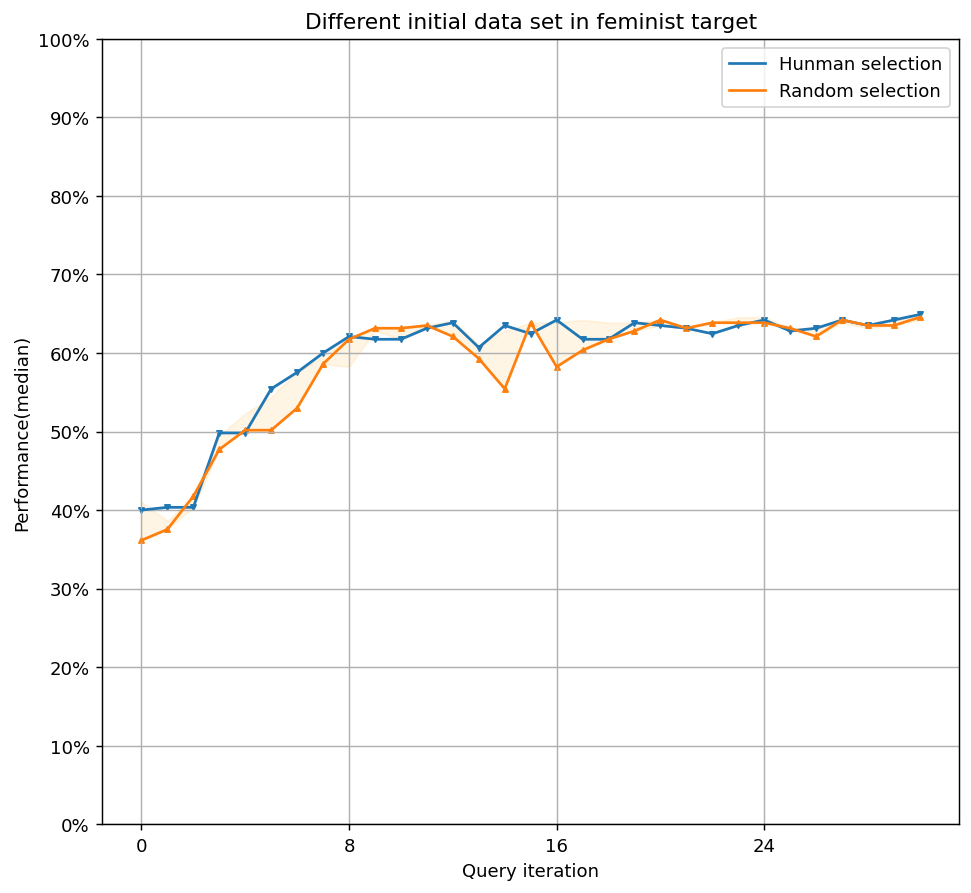

In [43]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(median_feminist1,label="Hunman selection")
ax.fill_between(range(31),min_feminist1,max_feminist1,color='blue', alpha=0.1)
ax.plot(median_feminist2,label="Random selection")
ax.fill_between(range(31),min_feminist2,max_feminist2,color='orange', alpha=0.1)

ax.scatter(range(31), median_feminist1, s=8,marker = "v")
ax.scatter(range(31), median_feminist2, s=8,marker="^")

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different initial data set in feminist target')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Performance(median)')

plt.show()

# Hillary

In [35]:
from datasets import load_dataset

cache_dir = "./data_cache"

train_dataset_hillary = load_dataset(
    "tweet_eval",
    name="stance_hillary",
    split="train",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Training dataset with {len(train_dataset_hillary)} instances loaded")

val_dataset_hillary = load_dataset(
    "tweet_eval",
    name="stance_hillary",
    split="validation",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Validation dataset with {len(val_dataset_hillary)} instances loaded")

test_dataset_hillary = load_dataset(
    "tweet_eval",
    name="stance_hillary",
    split="test",
    ignore_verifications=True,
    cache_dir=cache_dir,
)
print(f"Test dataset with {len(test_dataset_hillary)} instances loaded")

num_classes = np.unique(train_dataset_hillary['label']).size

Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_hillary\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Training dataset with 620 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_hillary\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Validation dataset with 69 instances loaded


Reusing dataset tweet_eval (./data_cache\tweet_eval\stance_hillary\1.1.0\12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


Test dataset with 295 instances loaded


In [36]:
from transformers import AutoModelForSequenceClassification

model_original = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=num_classes)

loading configuration file https://huggingface.co/prajjwal1/bert-tiny/resolve/main/config.json from cache at C:\Users\LYM/.cache\huggingface\transformers\3cf34679007e9fe5d0acd644dcc1f4b26bec5cbc9612364f6da7262aed4ef7a4.a5a11219cf90aae61ff30e1658ccf2cb4aa84d6b6e947336556f887c9828dc6d
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-tiny",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 2,
  "num_hidden_layers": 2,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_s

In [37]:
active_mc_hillary1 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
#     n_labeled_examples = np.unique(train_dataset_hillary['text']).size
#     training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
#     print(training_indices0)
    active_set_hillary =active_huggingface_dataset(train_dataset_hillary,tokenizer,'label','text')
    valid_set_hillary = HuggingFaceDatasets(test_dataset_hillary,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_hillary.can_label = False
    active_set_hillary.label([0,1,2,3,4,5,6,8,15])
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_hillary,
            eval_dataset=valid_set_hillary,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_hillary = ActiveLearningLoop(active_set_hillary,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_hillary=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_hillary.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_hillary.labelled_map,
            "Next Training set size": len(active_set_hillary),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_hillary.append(eval_metrics['eval_accuracy'])
    print(performance_history_hillary)
    active_mc_hillary1.append(performance_history_hillary)
    mcrun = mcrun + 1

***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:07:08.866129Z [info     ] Start Predict                  dataset=611


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 33.09it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:07:13.388130Z [info     ] Start Predict                  dataset=591


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 32.71it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:07:18.140129Z [info     ] Start Predict                  dataset=571


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 33.03it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:07:23.091152Z [info     ] Start Predict                  dataset=551


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 31.77it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:07:28.403899Z [info     ] Start Predict                  dataset=531


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 33.02it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:07:33.860900Z [info     ] Start Predict                  dataset=511


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.06it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:07:39.471898Z [info     ] Start Predict                  dataset=491


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 33.05it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:07:45.093929Z [info     ] Start Predict                  dataset=471


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 32.76it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:07:50.935959Z [info     ] Start Predict                  dataset=451


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 32.59it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:07:56.972928Z [info     ] Start Predict                  dataset=431


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.97it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:08:03.245414Z [info     ] Start Predict                  dataset=411


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.77it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:08:09.757414Z [info     ] Start Predict                  dataset=391


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.80it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:08:16.418415Z [info     ] Start Predict                  dataset=371


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 32.10it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:08:23.980008Z [info     ] Start Predict                  dataset=351


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.98it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:08:31.031006Z [info     ] Start Predict                  dataset=331


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 32.61it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:08:38.318115Z [info     ] Start Predict                  dataset=311


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.19it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:08:45.722083Z [info     ] Start Predict                  dataset=291


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 32.57it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:08:53.351055Z [info     ] Start Predict                  dataset=271


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.91it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:09:01.530056Z [info     ] Start Predict                  dataset=251


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.92it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:09:09.208055Z [info     ] Start Predict                  dataset=231


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.58it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:09:17.326059Z [info     ] Start Predict                  dataset=211


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.09it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:09:25.488055Z [info     ] Start Predict                  dataset=191


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.39it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:09:33.924058Z [info     ] Start Predict                  dataset=171


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 30.39it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:09:42.882057Z [info     ] Start Predict                  dataset=151


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.04it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:09:51.549212Z [info     ] Start Predict                  dataset=131


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 31.78it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:10:00.536241Z [info     ] Start Predict                  dataset=111


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.49it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:10:09.611211Z [info     ] Start Predict                  dataset=91


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.88it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:10:18.724211Z [info     ] Start Predict                  dataset=71


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.21it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:10:28.206212Z [info     ] Start Predict                  dataset=51


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 32.41it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:10:37.962085Z [info     ] Start Predict                  dataset=31


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 32.00it/s]


[0.2542372881355932, 0.27796610169491526, 0.2576271186440678, 0.2576271186440678, 0.28135593220338984, 0.2983050847457627, 0.2983050847457627, 0.2745762711864407, 0.31186440677966104, 0.376271186440678, 0.3389830508474576, 0.49830508474576274, 0.488135593220339, 0.5423728813559322, 0.5389830508474577, 0.5694915254237288, 0.5830508474576271, 0.5898305084745763, 0.5898305084745763, 0.6033898305084746, 0.5694915254237288, 0.5966101694915255, 0.5898305084745763, 0.5898305084745763, 0.5627118644067797, 0.5932203389830508, 0.5694915254237288, 0.5830508474576271, 0.5898305084745763, 0.5830508474576271, 0.5796610169491525]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:10:41.799087Z [info     ] Start Predict                  dataset=611


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 32.26it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:10:46.343142Z [info     ] Start Predict                  dataset=591


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 32.99it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:10:51.031141Z [info     ] Start Predict                  dataset=571


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 33.24it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:10:55.938142Z [info     ] Start Predict                  dataset=551


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 30.36it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:11:01.385142Z [info     ] Start Predict                  dataset=531


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 33.10it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:11:06.763905Z [info     ] Start Predict                  dataset=511


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 33.23it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:11:13.114694Z [info     ] Start Predict                  dataset=491


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 31.36it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:11:19.044694Z [info     ] Start Predict                  dataset=471


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 32.17it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:11:25.105697Z [info     ] Start Predict                  dataset=451


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.35it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:11:31.189725Z [info     ] Start Predict                  dataset=431


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.68it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:11:37.420113Z [info     ] Start Predict                  dataset=411


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 33.06it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:11:43.811110Z [info     ] Start Predict                  dataset=391


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.11it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:11:50.588113Z [info     ] Start Predict                  dataset=371


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.22it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:11:57.426110Z [info     ] Start Predict                  dataset=351


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 31.94it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:12:04.596630Z [info     ] Start Predict                  dataset=331


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 31.82it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:12:11.713632Z [info     ] Start Predict                  dataset=311


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.68it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:12:20.712629Z [info     ] Start Predict                  dataset=291


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.51it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:12:28.202820Z [info     ] Start Predict                  dataset=271


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:12:36.001849Z [info     ] Start Predict                  dataset=251


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:12:43.774819Z [info     ] Start Predict                  dataset=231


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.42it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:12:52.698824Z [info     ] Start Predict                  dataset=211


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.37it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:13:01.111731Z [info     ] Start Predict                  dataset=191


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.09it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:13:09.693246Z [info     ] Start Predict                  dataset=171


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:13:18.210218Z [info     ] Start Predict                  dataset=151


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.10it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:13:26.864220Z [info     ] Start Predict                  dataset=131


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.27it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:13:35.795225Z [info     ] Start Predict                  dataset=111


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.94it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:13:44.914227Z [info     ] Start Predict                  dataset=91


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.29it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:13:54.161225Z [info     ] Start Predict                  dataset=71


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:14:03.629239Z [info     ] Start Predict                  dataset=51


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 36.08it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:14:13.318239Z [info     ] Start Predict                  dataset=31


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 30.08it/s]


[0.2542372881355932, 0.27796610169491526, 0.2576271186440678, 0.2576271186440678, 0.28135593220338984, 0.2983050847457627, 0.2983050847457627, 0.2745762711864407, 0.31186440677966104, 0.376271186440678, 0.3389830508474576, 0.49830508474576274, 0.488135593220339, 0.5423728813559322, 0.5389830508474577, 0.5694915254237288, 0.5830508474576271, 0.5898305084745763, 0.5898305084745763, 0.6033898305084746, 0.5694915254237288, 0.5966101694915255, 0.5898305084745763, 0.5898305084745763, 0.5627118644067797, 0.5932203389830508, 0.5694915254237288, 0.5830508474576271, 0.5898305084745763, 0.5830508474576271, 0.5796610169491525]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:14:17.852237Z [info     ] Start Predict                  dataset=611


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 32.37it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:14:22.379237Z [info     ] Start Predict                  dataset=591


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 32.60it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:14:27.111239Z [info     ] Start Predict                  dataset=571


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 33.16it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:14:31.969237Z [info     ] Start Predict                  dataset=551


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 32.61it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:14:37.072267Z [info     ] Start Predict                  dataset=531


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 32.62it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:14:42.430237Z [info     ] Start Predict                  dataset=511


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 32.00it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:14:48.926237Z [info     ] Start Predict                  dataset=491


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 33.16it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:14:54.612241Z [info     ] Start Predict                  dataset=471


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 33.05it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:15:00.533239Z [info     ] Start Predict                  dataset=451


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 32.93it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:15:06.610241Z [info     ] Start Predict                  dataset=431


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.95it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:15:12.880237Z [info     ] Start Predict                  dataset=411


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.38it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:15:19.305238Z [info     ] Start Predict                  dataset=391


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 33.20it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:15:25.938237Z [info     ] Start Predict                  dataset=371


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 33.10it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:15:32.782236Z [info     ] Start Predict                  dataset=351


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.81it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:15:39.622238Z [info     ] Start Predict                  dataset=331


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.07it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:15:46.827236Z [info     ] Start Predict                  dataset=311


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.02it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:15:54.183240Z [info     ] Start Predict                  dataset=291


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 32.98it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:16:01.805045Z [info     ] Start Predict                  dataset=271


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.88it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:16:09.816591Z [info     ] Start Predict                  dataset=251


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.68it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:16:17.767593Z [info     ] Start Predict                  dataset=231


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.77it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:16:25.821610Z [info     ] Start Predict                  dataset=211


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.67it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:16:34.043611Z [info     ] Start Predict                  dataset=191


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.43it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:16:42.754610Z [info     ] Start Predict                  dataset=171


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.59it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:16:51.461611Z [info     ] Start Predict                  dataset=151


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.70it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:17:00.477589Z [info     ] Start Predict                  dataset=131


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.86it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:17:09.473592Z [info     ] Start Predict                  dataset=111


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.49it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:17:18.614132Z [info     ] Start Predict                  dataset=91


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.88it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:17:28.058102Z [info     ] Start Predict                  dataset=71


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.58it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:17:37.594646Z [info     ] Start Predict                  dataset=51


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.18it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:17:47.169646Z [info     ] Start Predict                  dataset=31


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.90it/s]


[0.2542372881355932, 0.27796610169491526, 0.2576271186440678, 0.2576271186440678, 0.28135593220338984, 0.2983050847457627, 0.2983050847457627, 0.2745762711864407, 0.31186440677966104, 0.376271186440678, 0.3389830508474576, 0.49830508474576274, 0.488135593220339, 0.5423728813559322, 0.5389830508474577, 0.5694915254237288, 0.5830508474576271, 0.5898305084745763, 0.5898305084745763, 0.6033898305084746, 0.5694915254237288, 0.5966101694915255, 0.5898305084745763, 0.5898305084745763, 0.5627118644067797, 0.5932203389830508, 0.5694915254237288, 0.5830508474576271, 0.5898305084745763, 0.5830508474576271, 0.5796610169491525]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:17:50.954159Z [info     ] Start Predict                  dataset=611


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 32.02it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:17:55.548187Z [info     ] Start Predict                  dataset=591


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 32.69it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:18:00.259158Z [info     ] Start Predict                  dataset=571


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 32.64it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:18:05.187158Z [info     ] Start Predict                  dataset=551


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 32.98it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:18:10.351157Z [info     ] Start Predict                  dataset=531


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 33.12it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:18:15.725156Z [info     ] Start Predict                  dataset=511


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 32.64it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:18:21.894677Z [info     ] Start Predict                  dataset=491


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:02<00:00, 29.57it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:18:27.925234Z [info     ] Start Predict                  dataset=471


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 32.05it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:18:33.949262Z [info     ] Start Predict                  dataset=451


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 31.79it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:18:40.020233Z [info     ] Start Predict                  dataset=431


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 31.54it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:18:46.347460Z [info     ] Start Predict                  dataset=411


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 31.53it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:18:52.789459Z [info     ] Start Predict                  dataset=391


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.41it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:18:59.347462Z [info     ] Start Predict                  dataset=371


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 32.39it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:19:06.168461Z [info     ] Start Predict                  dataset=351


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.98it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:19:13.087460Z [info     ] Start Predict                  dataset=331


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 32.63it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:19:20.295644Z [info     ] Start Predict                  dataset=311


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.83it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:19:27.642645Z [info     ] Start Predict                  dataset=291


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.45it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:19:35.502156Z [info     ] Start Predict                  dataset=271


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.44it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:19:43.392094Z [info     ] Start Predict                  dataset=251


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.72it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:19:51.380574Z [info     ] Start Predict                  dataset=231


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.47it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:19:59.274575Z [info     ] Start Predict                  dataset=211


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 34.09it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:20:07.446088Z [info     ] Start Predict                  dataset=191


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.43it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:20:15.925087Z [info     ] Start Predict                  dataset=171


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.38it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:20:24.481665Z [info     ] Start Predict                  dataset=151


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.51it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:20:33.193636Z [info     ] Start Predict                  dataset=131


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.20it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:20:42.084636Z [info     ] Start Predict                  dataset=111


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.02it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:20:51.203636Z [info     ] Start Predict                  dataset=91


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 33.80it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:21:00.440557Z [info     ] Start Predict                  dataset=71


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 32.61it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:21:09.891554Z [info     ] Start Predict                  dataset=51


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.53it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:21:19.543555Z [info     ] Start Predict                  dataset=31


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.61it/s]


[0.2542372881355932, 0.27796610169491526, 0.2576271186440678, 0.2576271186440678, 0.28135593220338984, 0.2983050847457627, 0.2983050847457627, 0.2745762711864407, 0.31186440677966104, 0.376271186440678, 0.3389830508474576, 0.49830508474576274, 0.488135593220339, 0.5423728813559322, 0.5389830508474577, 0.5694915254237288, 0.5830508474576271, 0.5898305084745763, 0.5898305084745763, 0.6033898305084746, 0.5694915254237288, 0.5966101694915255, 0.5898305084745763, 0.5898305084745763, 0.5627118644067797, 0.5932203389830508, 0.5694915254237288, 0.5830508474576271, 0.5898305084745763, 0.5830508474576271, 0.5796610169491525]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:21:23.318555Z [info     ] Start Predict                  dataset=611


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 32.72it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:21:27.823557Z [info     ] Start Predict                  dataset=591


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 32.96it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:21:32.568556Z [info     ] Start Predict                  dataset=571


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 32.19it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:21:37.522557Z [info     ] Start Predict                  dataset=551


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 31.89it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:21:42.835555Z [info     ] Start Predict                  dataset=531


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 32.49it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:21:48.192555Z [info     ] Start Predict                  dataset=511


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 32.05it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:21:53.697573Z [info     ] Start Predict                  dataset=491


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 31.90it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:21:59.350907Z [info     ] Start Predict                  dataset=471


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 32.42it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:22:05.338449Z [info     ] Start Predict                  dataset=451


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 32.73it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:22:11.351100Z [info     ] Start Predict                  dataset=431


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.45it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:22:17.521126Z [info     ] Start Predict                  dataset=411


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.08it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:22:23.873156Z [info     ] Start Predict                  dataset=391


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 31.27it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:22:30.709156Z [info     ] Start Predict                  dataset=371


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 32.98it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:22:37.533125Z [info     ] Start Predict                  dataset=351


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.21it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:22:44.585127Z [info     ] Start Predict                  dataset=331


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 30.75it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:22:52.027157Z [info     ] Start Predict                  dataset=311


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.81it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:22:59.390126Z [info     ] Start Predict                  dataset=291


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 31.36it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:23:07.279547Z [info     ] Start Predict                  dataset=271


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 30.47it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:23:15.652548Z [info     ] Start Predict                  dataset=251


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 28.93it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:23:24.359549Z [info     ] Start Predict                  dataset=231


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 33.06it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:23:32.456617Z [info     ] Start Predict                  dataset=211


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.71it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:23:41.127779Z [info     ] Start Predict                  dataset=191


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 34.14it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:23:49.487807Z [info     ] Start Predict                  dataset=171


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:23:58.101803Z [info     ] Start Predict                  dataset=151


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:24:06.736028Z [info     ] Start Predict                  dataset=131


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.41it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:24:15.492041Z [info     ] Start Predict                  dataset=111


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.90it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:24:25.071590Z [info     ] Start Predict                  dataset=91


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 33.99it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:24:34.401208Z [info     ] Start Predict                  dataset=71


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.96it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:24:43.947855Z [info     ] Start Predict                  dataset=51


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 36.08it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:24:53.606839Z [info     ] Start Predict                  dataset=31


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.25it/s]


[0.2542372881355932, 0.27796610169491526, 0.2576271186440678, 0.2576271186440678, 0.28135593220338984, 0.2983050847457627, 0.2983050847457627, 0.2745762711864407, 0.31186440677966104, 0.376271186440678, 0.3389830508474576, 0.49830508474576274, 0.488135593220339, 0.5423728813559322, 0.5389830508474577, 0.5694915254237288, 0.5830508474576271, 0.5898305084745763, 0.5898305084745763, 0.6033898305084746, 0.5694915254237288, 0.5966101694915255, 0.5898305084745763, 0.5898305084745763, 0.5627118644067797, 0.5932203389830508, 0.5694915254237288, 0.5830508474576271, 0.5898305084745763, 0.5830508474576271, 0.5796610169491525]


In [38]:
active_mc_hillary2 = []
mcrun = 0
al_epochs=30
np.random.seed()
while mcrun != 5:
#     n_labeled_examples = np.unique(train_dataset_hillary['text']).size
#     training_indices0 = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)
#     print(training_indices0)
    active_set_hillary =active_huggingface_dataset(train_dataset_hillary,tokenizer,'label','text')
    valid_set_hillary = HuggingFaceDatasets(test_dataset_hillary,tokenizer,'label','text')
    # # lets randomly label 100 samples, therefore len(active_set) should be 100
    active_set_hillary.can_label = False
    active_set_hillary.label_randomly(9)
    from baal.active import get_heuristic
    heuristic = get_heuristic('entropy')
    model = patch_module(model_original)
    init_weights = deepcopy(model.state_dict())

    def compute_metrics(p):
        label = p.label_ids
        preds = np.argmax(p.predictions, axis=-1)
        return {
            'accuracy': accuracy_score(label, preds),
        }
    model = BaalTransformersTrainer(
            model=model,
            args=training_args,
            train_dataset=active_set_hillary,
            eval_dataset=valid_set_hillary,
            tokenizer=None,
            compute_metrics=compute_metrics)
    active_loop_hillary = ActiveLearningLoop(active_set_hillary,
                                 model.predict_on_dataset,
                                 heuristic, 20, iterations=1)
    model.train()
    unqueried_score=model.evaluate()['eval_accuracy']
    performance_history_hillary=[unqueried_score]
    for epoch in range(al_epochs):
        model.train()
        eval_metrics = model.evaluate()
        should_continue = active_loop_hillary.step()
        model.load_state_dict(init_weights)
        model.lr_scheduler = None
        if not should_continue:
                break
        active_logs = {
            "epoch": epoch,
            "labeled_data": active_set_hillary.labelled_map,
            "Next Training set size": len(active_set_hillary),
        }

        logs = {**eval_metrics, **active_logs}
        performance_history_hillary.append(eval_metrics['eval_accuracy'])
    print(performance_history_hillary)
    active_mc_hillary2.append(performance_history_hillary)
    mcrun = mcrun + 1

D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:24:57.569361Z [info     ] Start Predict                  dataset=611


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 31.75it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:25:02.139359Z [info     ] Start Predict                  dataset=591


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 32.76it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:25:06.925900Z [info     ] Start Predict                  dataset=571


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 32.94it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:25:11.936200Z [info     ] Start Predict                  dataset=551


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 32.17it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:25:17.091150Z [info     ] Start Predict                  dataset=531


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 26.55it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:25:23.572632Z [info     ] Start Predict                  dataset=511


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 27.59it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:25:29.482166Z [info     ] Start Predict                  dataset=491


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 32.21it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:25:35.246165Z [info     ] Start Predict                  dataset=471


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 29.80it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:25:41.398166Z [info     ] Start Predict                  dataset=451


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 32.37it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:25:47.485682Z [info     ] Start Predict                  dataset=431


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.39it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:25:53.898680Z [info     ] Start Predict                  dataset=411


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.44it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:26:00.298682Z [info     ] Start Predict                  dataset=391


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.51it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:26:07.116712Z [info     ] Start Predict                  dataset=371


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 32.02it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:26:14.021425Z [info     ] Start Predict                  dataset=351


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.12it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:26:21.088426Z [info     ] Start Predict                  dataset=331


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 32.46it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:26:28.381091Z [info     ] Start Predict                  dataset=311


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 31.71it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:26:35.680089Z [info     ] Start Predict                  dataset=291


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.27it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:26:43.996709Z [info     ] Start Predict                  dataset=271


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.88it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:26:51.713148Z [info     ] Start Predict                  dataset=251


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.75it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:26:59.480149Z [info     ] Start Predict                  dataset=231


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.73it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:27:07.353149Z [info     ] Start Predict                  dataset=211


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.46it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:27:15.547249Z [info     ] Start Predict                  dataset=191


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 32.83it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:27:23.883247Z [info     ] Start Predict                  dataset=171


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.79it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:27:32.376249Z [info     ] Start Predict                  dataset=151


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 32.31it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:27:41.032247Z [info     ] Start Predict                  dataset=131


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.21it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:27:49.932250Z [info     ] Start Predict                  dataset=111


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.33it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:27:59.262276Z [info     ] Start Predict                  dataset=91


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.99it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:28:08.523246Z [info     ] Start Predict                  dataset=71


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.83it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:28:18.049678Z [info     ] Start Predict                  dataset=51


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.71it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:28:27.608681Z [info     ] Start Predict                  dataset=31


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.06it/s]


[0.26440677966101694, 0.2745762711864407, 0.26440677966101694, 0.2576271186440678, 0.3016949152542373, 0.3152542372881356, 0.33220338983050846, 0.33559322033898303, 0.39322033898305087, 0.43050847457627117, 0.41694915254237286, 0.3864406779661017, 0.46779661016949153, 0.5491525423728814, 0.5152542372881356, 0.5152542372881356, 0.5559322033898305, 0.5694915254237288, 0.5050847457627119, 0.5830508474576271, 0.5728813559322034, 0.5864406779661017, 0.5830508474576271, 0.5898305084745763, 0.5898305084745763, 0.5898305084745763, 0.5796610169491525, 0.5796610169491525, 0.5898305084745763, 0.5830508474576271, 0.5830508474576271]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:28:31.519701Z [info     ] Start Predict                  dataset=611


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 32.14it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:28:36.139713Z [info     ] Start Predict                  dataset=591


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 32.77it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:28:40.936715Z [info     ] Start Predict                  dataset=571


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 32.37it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:28:45.886716Z [info     ] Start Predict                  dataset=551


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 33.00it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:28:51.035713Z [info     ] Start Predict                  dataset=531


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 32.71it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:28:56.348713Z [info     ] Start Predict                  dataset=511


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 31.79it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:29:02.027713Z [info     ] Start Predict                  dataset=491


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 33.23it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:29:07.582234Z [info     ] Start Predict                  dataset=471


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 32.07it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:29:13.546238Z [info     ] Start Predict                  dataset=451


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.02it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:29:19.486234Z [info     ] Start Predict                  dataset=431


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.87it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:29:25.844234Z [info     ] Start Predict                  dataset=411


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.36it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:29:32.345237Z [info     ] Start Predict                  dataset=391


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.60it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:29:39.000233Z [info     ] Start Predict                  dataset=371


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 32.87it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:29:45.673233Z [info     ] Start Predict                  dataset=351


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 31.53it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:29:52.750592Z [info     ] Start Predict                  dataset=331


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.71it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:29:59.956563Z [info     ] Start Predict                  dataset=311


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.37it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:30:07.314562Z [info     ] Start Predict                  dataset=291


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.36it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:30:14.805079Z [info     ] Start Predict                  dataset=271


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.60it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:30:22.791593Z [info     ] Start Predict                  dataset=251


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 32.75it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:30:30.563594Z [info     ] Start Predict                  dataset=231


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.69it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:30:38.616098Z [info     ] Start Predict                  dataset=211


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 32.49it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:30:46.673101Z [info     ] Start Predict                  dataset=191


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.01it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:30:55.087127Z [info     ] Start Predict                  dataset=171


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.90it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:31:03.646654Z [info     ] Start Predict                  dataset=151


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.04it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:31:12.757517Z [info     ] Start Predict                  dataset=131


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.46it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:31:21.771622Z [info     ] Start Predict                  dataset=111


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.63it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:31:30.875294Z [info     ] Start Predict                  dataset=91


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.29it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:31:40.268828Z [info     ] Start Predict                  dataset=71


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.46it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:31:49.657798Z [info     ] Start Predict                  dataset=51


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 36.27it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:31:59.174810Z [info     ] Start Predict                  dataset=31


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 34.78it/s]


[0.2576271186440678, 0.2745762711864407, 0.2542372881355932, 0.2576271186440678, 0.2711864406779661, 0.2745762711864407, 0.29491525423728815, 0.29491525423728815, 0.33220338983050846, 0.39661016949152544, 0.36610169491525424, 0.4542372881355932, 0.5186440677966102, 0.5423728813559322, 0.5016949152542373, 0.5830508474576271, 0.576271186440678, 0.5966101694915255, 0.5491525423728814, 0.6067796610169491, 0.5627118644067797, 0.5830508474576271, 0.5491525423728814, 0.5932203389830508, 0.5932203389830508, 0.5932203389830508, 0.5864406779661017, 0.5796610169491525, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:32:03.087808Z [info     ] Start Predict                  dataset=611


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 32.12it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:32:07.608810Z [info     ] Start Predict                  dataset=591


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 33.05it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:32:12.263811Z [info     ] Start Predict                  dataset=571


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 33.23it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:32:17.201810Z [info     ] Start Predict                  dataset=551


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 33.05it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:32:22.317812Z [info     ] Start Predict                  dataset=531


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:01<00:00, 33.70it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:32:27.663810Z [info     ] Start Predict                  dataset=511


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 32.96it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:32:33.197809Z [info     ] Start Predict                  dataset=491


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 31.99it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:32:38.874490Z [info     ] Start Predict                  dataset=471


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 32.22it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:32:44.770011Z [info     ] Start Predict                  dataset=451


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 31.77it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:32:50.943015Z [info     ] Start Predict                  dataset=431


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.63it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:32:57.178011Z [info     ] Start Predict                  dataset=411


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.75it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:33:03.625042Z [info     ] Start Predict                  dataset=391


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.45it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:33:10.226013Z [info     ] Start Predict                  dataset=371


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 32.94it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:33:17.034632Z [info     ] Start Predict                  dataset=351


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 31.70it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:33:24.051601Z [info     ] Start Predict                  dataset=331


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.25it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:33:31.027601Z [info     ] Start Predict                  dataset=311


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 32.91it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:33:38.736969Z [info     ] Start Predict                  dataset=291


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 33.42it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:33:46.150969Z [info     ] Start Predict                  dataset=271


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.76it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:33:53.894969Z [info     ] Start Predict                  dataset=251


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.40it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:34:01.552967Z [info     ] Start Predict                  dataset=231


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 31.02it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:34:09.582968Z [info     ] Start Predict                  dataset=211


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 34.20it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:34:17.658491Z [info     ] Start Predict                  dataset=191


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 30.61it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:34:26.063486Z [info     ] Start Predict                  dataset=171


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.38it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:34:34.620488Z [info     ] Start Predict                  dataset=151


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.10it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:34:43.408487Z [info     ] Start Predict                  dataset=131


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 30.14it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:34:52.362487Z [info     ] Start Predict                  dataset=111


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.11it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:35:01.467490Z [info     ] Start Predict                  dataset=91


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.19it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:35:10.773489Z [info     ] Start Predict                  dataset=71


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.58it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:35:20.182489Z [info     ] Start Predict                  dataset=51


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 34.65it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:35:29.842490Z [info     ] Start Predict                  dataset=31


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 31.75it/s]


[0.2576271186440678, 0.2745762711864407, 0.2542372881355932, 0.2576271186440678, 0.2711864406779661, 0.2745762711864407, 0.29491525423728815, 0.29491525423728815, 0.33220338983050846, 0.39661016949152544, 0.36610169491525424, 0.4542372881355932, 0.5186440677966102, 0.5423728813559322, 0.5016949152542373, 0.5830508474576271, 0.576271186440678, 0.5966101694915255, 0.5491525423728814, 0.6067796610169491, 0.5627118644067797, 0.5830508474576271, 0.5491525423728814, 0.5932203389830508, 0.5932203389830508, 0.5932203389830508, 0.5864406779661017, 0.5796610169491525, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:35:33.798924Z [info     ] Start Predict                  dataset=611


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 32.49it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:35:38.396989Z [info     ] Start Predict                  dataset=591


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 32.63it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:35:43.149992Z [info     ] Start Predict                  dataset=571


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 31.62it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:35:48.156512Z [info     ] Start Predict                  dataset=551


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 31.81it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:35:53.288525Z [info     ] Start Predict                  dataset=531


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 32.78it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:35:58.702526Z [info     ] Start Predict                  dataset=511


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 31.75it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:36:04.234524Z [info     ] Start Predict                  dataset=491


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 32.65it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:36:10.055039Z [info     ] Start Predict                  dataset=471


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 31.77it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:36:16.028040Z [info     ] Start Predict                  dataset=451


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 31.56it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:36:22.253040Z [info     ] Start Predict                  dataset=431


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 32.77it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:36:28.568043Z [info     ] Start Predict                  dataset=411


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:36:34.998039Z [info     ] Start Predict                  dataset=391


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.68it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:36:41.703605Z [info     ] Start Predict                  dataset=371


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 32.71it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:36:48.740633Z [info     ] Start Predict                  dataset=351


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 32.81it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:36:56.207605Z [info     ] Start Predict                  dataset=331


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 33.28it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:37:03.449149Z [info     ] Start Predict                  dataset=311


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.16it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:37:11.403149Z [info     ] Start Predict                  dataset=291


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 31.87it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:37:19.014607Z [info     ] Start Predict                  dataset=271


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 33.27it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:37:26.968636Z [info     ] Start Predict                  dataset=251


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 33.09it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:37:34.768644Z [info     ] Start Predict                  dataset=231


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.19it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:37:42.820002Z [info     ] Start Predict                  dataset=211


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.21it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:37:51.034971Z [info     ] Start Predict                  dataset=191


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 33.24it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:37:59.296971Z [info     ] Start Predict                  dataset=171


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 33.69it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:38:07.887972Z [info     ] Start Predict                  dataset=151


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.51it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:38:16.632972Z [info     ] Start Predict                  dataset=131


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 34.41it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:38:25.740485Z [info     ] Start Predict                  dataset=111


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 33.25it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:38:34.836519Z [info     ] Start Predict                  dataset=91


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 34.48it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:38:44.142519Z [info     ] Start Predict                  dataset=71


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.96it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:38:53.629518Z [info     ] Start Predict                  dataset=51


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 35.90it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:39:03.322519Z [info     ] Start Predict                  dataset=31


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 34.19it/s]


[0.2576271186440678, 0.2745762711864407, 0.2542372881355932, 0.2576271186440678, 0.2711864406779661, 0.2745762711864407, 0.29491525423728815, 0.29491525423728815, 0.33220338983050846, 0.39661016949152544, 0.36610169491525424, 0.4542372881355932, 0.5186440677966102, 0.5423728813559322, 0.5016949152542373, 0.5830508474576271, 0.576271186440678, 0.5966101694915255, 0.5491525423728814, 0.6067796610169491, 0.5627118644067797, 0.5830508474576271, 0.5491525423728814, 0.5932203389830508, 0.5932203389830508, 0.5932203389830508, 0.5864406779661017, 0.5796610169491525, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271]


D:\Users\LYM\miniconda3\envs\data_analytics_course0\lib\site-packages\baal\bayesian\common.py:62: UserWarning: No layer was modified by patch_module!
  warnings.warn("No layer was modified by patch_module!", UserWarning)
***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


***** Running training *****
  Num examples = 9
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:39:07.235517Z [info     ] Start Predict                  dataset=611


100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:02<00:00, 32.33it/s]
***** Running training *****
  Num examples = 29
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:39:11.780517Z [info     ] Start Predict                  dataset=591


100%|██████████████████████████████████████████████████████████████████████████████████| 74/74 [00:02<00:00, 32.31it/s]
***** Running training *****
  Num examples = 49
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 7


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:39:16.566518Z [info     ] Start Predict                  dataset=571


100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:02<00:00, 32.85it/s]
***** Running training *****
  Num examples = 69
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 9


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:39:21.452087Z [info     ] Start Predict                  dataset=551


100%|██████████████████████████████████████████████████████████████████████████████████| 69/69 [00:02<00:00, 32.67it/s]
***** Running training *****
  Num examples = 89
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 12


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:39:26.556108Z [info     ] Start Predict                  dataset=531


100%|██████████████████████████████████████████████████████████████████████████████████| 67/67 [00:02<00:00, 31.68it/s]
***** Running training *****
  Num examples = 109
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 14


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:39:31.979114Z [info     ] Start Predict                  dataset=511


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 31.31it/s]
***** Running training *****
  Num examples = 129
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 17


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:39:38.103137Z [info     ] Start Predict                  dataset=491


100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:01<00:00, 32.21it/s]
***** Running training *****
  Num examples = 149
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:39:43.866105Z [info     ] Start Predict                  dataset=471


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:01<00:00, 31.62it/s]
***** Running training *****
  Num examples = 169
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 22


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:39:50.199699Z [info     ] Start Predict                  dataset=451


100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [00:01<00:00, 33.04it/s]
***** Running training *****
  Num examples = 189
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 24


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:39:56.226658Z [info     ] Start Predict                  dataset=431


100%|██████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 33.07it/s]
***** Running training *****
  Num examples = 209
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 27


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:40:02.569216Z [info     ] Start Predict                  dataset=411


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:01<00:00, 32.93it/s]
***** Running training *****
  Num examples = 229
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 29


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:40:09.345247Z [info     ] Start Predict                  dataset=391


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:01<00:00, 32.75it/s]
***** Running training *****
  Num examples = 249
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 32


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:40:15.880740Z [info     ] Start Predict                  dataset=371


100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:01<00:00, 31.78it/s]
***** Running training *****
  Num examples = 269
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 34


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:40:22.745769Z [info     ] Start Predict                  dataset=351


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:01<00:00, 31.12it/s]
***** Running training *****
  Num examples = 289
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 37


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:40:29.851739Z [info     ] Start Predict                  dataset=331


100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:01<00:00, 32.94it/s]
***** Running training *****
  Num examples = 309
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 39


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:40:36.913741Z [info     ] Start Predict                  dataset=311


100%|██████████████████████████████████████████████████████████████████████████████████| 39/39 [00:01<00:00, 33.02it/s]
***** Running training *****
  Num examples = 329
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 42


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:40:44.306739Z [info     ] Start Predict                  dataset=291


100%|██████████████████████████████████████████████████████████████████████████████████| 37/37 [00:01<00:00, 31.60it/s]
***** Running training *****
  Num examples = 349
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:40:51.864254Z [info     ] Start Predict                  dataset=271


100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:01<00:00, 32.44it/s]
***** Running training *****
  Num examples = 369
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 47


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:40:59.637006Z [info     ] Start Predict                  dataset=251


100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 31.07it/s]
***** Running training *****
  Num examples = 389
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 49


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:41:07.602528Z [info     ] Start Predict                  dataset=231


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 32.58it/s]
***** Running training *****
  Num examples = 409
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 52


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:41:15.619580Z [info     ] Start Predict                  dataset=211


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:00<00:00, 33.37it/s]
***** Running training *****
  Num examples = 429
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:41:23.793236Z [info     ] Start Predict                  dataset=191


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 31.13it/s]
***** Running training *****
  Num examples = 449
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 57


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:41:33.285266Z [info     ] Start Predict                  dataset=171


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 32.89it/s]
***** Running training *****
  Num examples = 469
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 59


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:41:41.821265Z [info     ] Start Predict                  dataset=151


100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 33.16it/s]
***** Running training *****
  Num examples = 489
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 62


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:41:50.544308Z [info     ] Start Predict                  dataset=131


100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 33.80it/s]
***** Running training *****
  Num examples = 509
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 64


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:41:59.377800Z [info     ] Start Predict                  dataset=111


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 32.94it/s]
***** Running training *****
  Num examples = 529
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 67


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:42:08.419801Z [info     ] Start Predict                  dataset=91


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 33.90it/s]
***** Running training *****
  Num examples = 549
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 69


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:42:17.719345Z [info     ] Start Predict                  dataset=71


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 33.58it/s]
***** Running training *****
  Num examples = 569
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 72


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:42:27.080348Z [info     ] Start Predict                  dataset=51


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 34.83it/s]
***** Running training *****
  Num examples = 589
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 74


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 295
  Batch size = 8


[3372-MainThread ] [baal.transformers_trainer_wrapper:predict_on_dataset_generator:67] 2022-09-05T13:42:36.728346Z [info     ] Start Predict                  dataset=31


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 33.61it/s]


[0.2576271186440678, 0.2745762711864407, 0.2542372881355932, 0.2576271186440678, 0.2711864406779661, 0.2745762711864407, 0.29491525423728815, 0.29491525423728815, 0.33220338983050846, 0.39661016949152544, 0.36610169491525424, 0.4542372881355932, 0.5186440677966102, 0.5423728813559322, 0.5016949152542373, 0.5830508474576271, 0.576271186440678, 0.5966101694915255, 0.5491525423728814, 0.6067796610169491, 0.5627118644067797, 0.5830508474576271, 0.5491525423728814, 0.5932203389830508, 0.5932203389830508, 0.5932203389830508, 0.5864406779661017, 0.5796610169491525, 0.5864406779661017, 0.5830508474576271, 0.5830508474576271]


In [39]:
median_hillary1, min_hillary1,max_hillary1 = calculate(active_mc_hillary1)

In [40]:
median_hillary2, min_hillary2,max_hillary2= calculate(active_mc_hillary2)

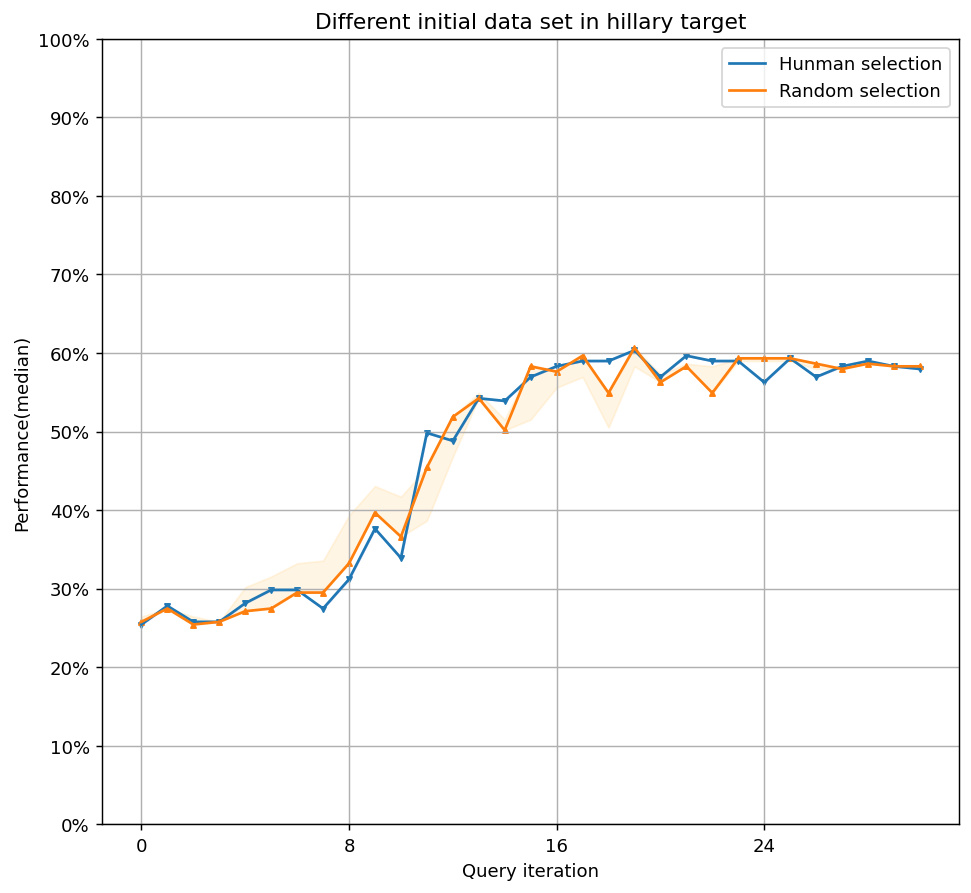

In [41]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8.5, 8), dpi=130)
ax.plot(median_hillary1,label="Hunman selection")
ax.fill_between(range(31),min_hillary1,max_hillary1,color='blue', alpha=0.1)
ax.plot(median_hillary2,label="Random selection")
ax.fill_between(range(31),min_hillary2,max_hillary2,color='orange', alpha=0.1)


ax.scatter(range(31), median_hillary1, s=8,marker = "v")
ax.scatter(range(31), median_hillary2, s=8,marker="^")

ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)
ax.legend()
ax.set_title('Different initial data set in hillary target')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Performance(median)')

plt.show()